In [5]:
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import contextlib
import logging

import numpy as np
import pandas as pd
import seaborn as sns

import anndata as ad
import spatialdata as sd
import spatialdata_plot
from spatialdata import SpatialData, polygon_query
from spatialdata_io import xenium

import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi
import sys
import gseapy as gp

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib_venn import venn3
from matplotlib.colors import ListedColormap

from lightning.pytorch import seed_everything
from collections import Counter

import os
import mygene
import copy

from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, adjusted_rand_score, normalized_mutual_info_score, silhouette_score, silhouette_samples
import scipy.stats as stats
from scipy.stats import gaussian_kde, pearsonr, ks_2samp, mannwhitneyu, chi2_contingency

In [6]:
xenium = sd.read_zarr("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")

In [7]:
classification_df = pd.read_csv('/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_cell_types.csv')

In [8]:
# Clustering unimodale (con caratteristiche molecolari)
molecular_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_molecular_mild-dawn-408.csv")

In [9]:
molecular_single_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_molecular_epithelial.csv")

In [10]:
# Clustering unimodale (con caratteristiche istologiche)
histological_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_phikon_icy-salad-378.csv")

In [11]:
histological_single_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_histology_epithelial.csv")

In [12]:
# Clustering integrato (con caratteristiche molecolari e istologiche)
integrative_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_multi_proud_rain_419.csv")

In [13]:
# Carico il file 'epithelial_cells' che contiene solo le cellule epiteliali e filtrato per total_counts
epithelial_cells = sc.read_h5ad("epithelial_cells_cell_type_prediction_filtered.h5ad")

In [14]:
def create_feature_anndata(epithelial_cells, feature_df, obsm_key):
    # Se 'cell_id' è colonna, usala come indice
    if "cell_id" in feature_df.columns:
        feature_df = feature_df.set_index("cell_id")

    # Converte a stringa per allineare
    obs_ids = epithelial_cells.obs['cell_id'].astype(str)
    feature_df.index = feature_df.index.astype(str)

    # Trova le celle comuni
    common_cells = obs_ids[obs_ids.isin(feature_df.index)]
    adata_filtered = epithelial_cells[common_cells.index].copy()

    # Allinea le features nell'ordine giusto
    feature_aligned = feature_df.loc[common_cells]

    # Inserisci le features
    adata_filtered.obsm[obsm_key] = feature_aligned.astype("float32").to_numpy()
    adata_filtered.uns[obsm_key + "_feature_names"] = feature_aligned.columns.tolist()

    print(f"Features added to `{obsm_key}`. {adata_filtered.n_obs} cells, {feature_aligned.shape[1]} features.")
    return adata_filtered

# FEATURES DEI 6 CAMPIONNI
adata_molecular_features = create_feature_anndata(epithelial_cells, molecular_features, "molecular_features")
adata_histological_features = create_feature_anndata(epithelial_cells, histological_features, "histological_features")
adata_integrative_features = create_feature_anndata(epithelial_cells, integrative_features, "integrative_features")
# SINGLE FEATURES = FEATURE SPECIFICHE DEL CAMPIONE E SOLO DELLE CELLULE EPITELIALI
adata_molecular_single_features = create_feature_anndata(epithelial_cells, molecular_single_features, "molecular_single_features")
adata_histological_single_features = create_feature_anndata(epithelial_cells, histological_single_features, "histological_single_features")

Features added to `molecular_features`. 348692 cells, 32 features.
Features added to `histological_features`. 348692 cells, 32 features.
Features added to `integrative_features`. 348692 cells, 32 features.
Features added to `molecular_single_features`. 348692 cells, 10 features.
Features added to `histological_single_features`. 348692 cells, 10 features.


In [15]:
# Downsampling con seed per avere campioni uguali da confrontare
def downsample_adata(adata, label_key="cell_type_prediction", n_per_class=25000, seed=42):
    rng = np.random.default_rng(seed)  # inizializzo il generatore con seed
    idxs = []
    for cat in adata.obs[label_key].unique():
        cat_idx = np.where(adata.obs[label_key] == cat)[0]
        if len(cat_idx) > n_per_class:
            chosen = rng.choice(cat_idx, n_per_class, replace=False)  
        else:
            chosen = cat_idx
        idxs.extend(chosen)
    
    return adata[idxs].copy()

adata_molecular_single_features_down = downsample_adata(adata_molecular_single_features, n_per_class=25000, seed=42)
adata_histological_single_features_down = downsample_adata(adata_histological_single_features, n_per_class=25000, seed=42)

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

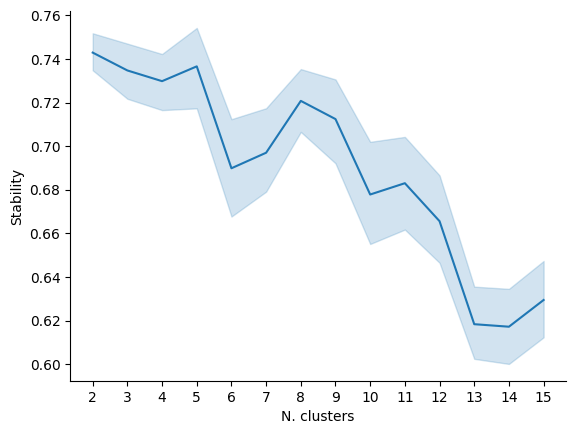

In [747]:
# ClusterAutoK sulle MOLECULAR SINGLE FEATURES DOWN UNSCALED k=5
autok_molecular_single_features_unscaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15), 
    max_runs=10,
    convergence_tol=0.001)

autok_molecular_single_features_unscaled.fit(
    adata_molecular_single_features_down, 
    use_rep='molecular_single_features')

# Visualizzazione stabilità cluster
ax = cc.pl.autok_stability(autok_molecular_single_features_unscaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "molecular_single_features_unscaled_autok_plot.pdf", dpi=300)

# Salvataggio modello
save_path = Path("saved_models_final/molecular_single_features_unscaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_molecular_single_features_unscaled.save(save_path, best_k=False)

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

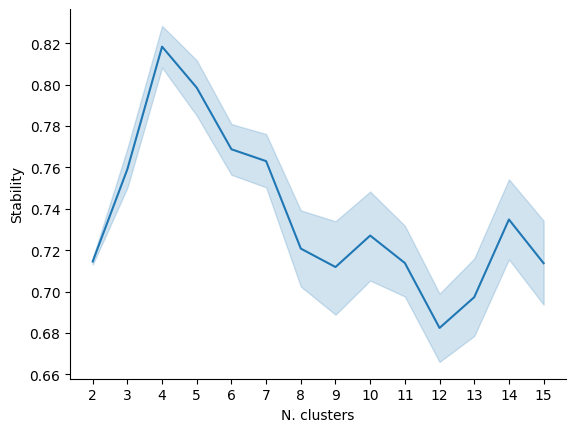

In [741]:
# ClusterAutoK sulle HISTOLOGICAL SINGLE FEATURES DOWN UNSCALED k=4

autok_histological_single_features_unscaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15),
    max_runs=10,
    convergence_tol=0.001)

autok_histological_single_features_unscaled.fit(
    adata_histological_single_features_down,
    use_rep='histological_single_features')

# Visualizzazione stabilità cluster
ax = cc.pl.autok_stability(autok_histological_single_features_unscaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "histological_single_features_unscaled_autok_plot.pdf", dpi=300)

# Salvataggio modello
save_path = Path("saved_models_final/histological_single_features_unscaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_histological_single_features_unscaled.save(save_path, best_k=False)

In [16]:
def standardize_features(adata, obsm_key, new_obsm_key):
    scaler = StandardScaler()
    X = adata.obsm[obsm_key]
    X_scaled = scaler.fit_transform(X)
    adata.obsm[new_obsm_key] = X_scaled
    return adata

adata_molecular_single_features_down = standardize_features(
    adata_molecular_single_features_down,
    obsm_key="molecular_single_features",
    new_obsm_key="molecular_single_features_scaled")

adata_histological_single_features_down = standardize_features(
    adata_histological_single_features_down,
    obsm_key="histological_single_features",
    new_obsm_key="histological_single_features_scaled")

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

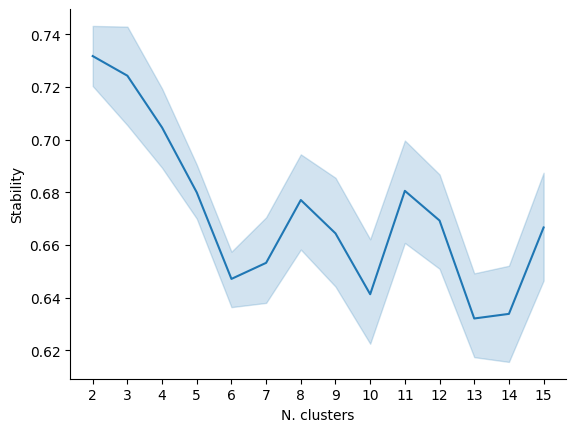

In [748]:
# ClusterAutok sulle MOLECULAR SINGLE FEATURES DOWN SCALED k=2

autok_molecular_single_features_scaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15),
    max_runs=10,
    convergence_tol=0.001)

autok_molecular_single_features_scaled.fit(
    adata_molecular_single_features_down, 
    use_rep='molecular_single_features_scaled')

# Visualizzazione stabilità cluster
ax = cc.pl.autok_stability(autok_molecular_single_features_scaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "molecular_single_features_scaled_autok_plot.pdf", dpi=300)

# Salvataggio modello
save_path = Path("saved_models_final/molecular_single_features_scaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_molecular_single_features_scaled.save(save_path, best_k=False)

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

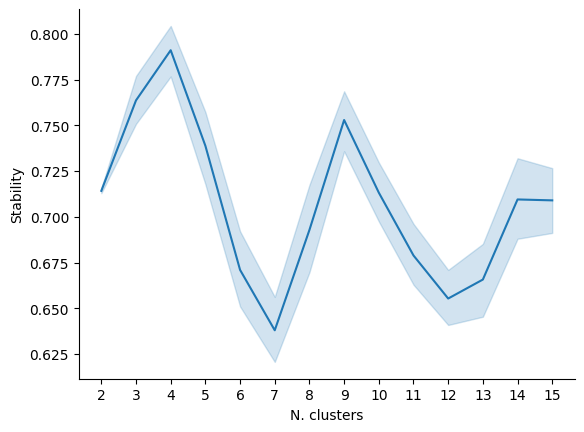

In [743]:
# ClusterAutoK sulle HISTOLOGICAL SINGLE FEATURES SCALED k=4

autok_histological_single_features_scaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15),
    max_runs=10,
    convergence_tol=0.001)

autok_histological_single_features_scaled.fit(
    adata_histological_single_features_down,
    use_rep='histological_single_features_scaled')

# Visualizzazione stabilità cluster
ax = cc.pl.autok_stability(autok_histological_single_features_scaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "histological_single_features_scaled_autok_plot.pdf", dpi=300)

# Salvataggio modello
save_path = Path("saved_models_final/histological_single_features_scaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_histological_single_features_scaled.save(save_path, best_k=False)

In [17]:
# Carico i modelli autok salvati e faccio AutoK.predict nei rispettivi anndata con le rispettive features

# MOLECULAR_SINGLE_FEATURES_DOWN_UNSCALED k=5     
autok_molecular_single_features_down_unscaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/molecular_single_features_unscaled_autok")
adata_molecular_single_features_down.obs['cluster_5_unscaled'] = autok_molecular_single_features_down_unscaled_loaded.predict(
    adata_molecular_single_features_down, use_rep='molecular_single_features', k=5)

# MOLECULAR_SINGLE_FEATURES_DOWN_SCALED k=2    
autok_molecular_single_features_down_scaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/molecular_single_features_scaled_autok")
adata_molecular_single_features_down.obs['cluster_2_scaled'] = autok_molecular_single_features_down_scaled_loaded.predict(
    adata_molecular_single_features_down, use_rep='molecular_single_features_scaled', k=2)


# HISTOLOGICAL_SINGLE_FEATURES_DOWN_UNSCALED k=4   
autok_histological_single_features_down_unscaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/histological_single_features_unscaled_autok")
adata_histological_single_features_down.obs['cluster_4_unscaled'] = autok_histological_single_features_down_unscaled_loaded.predict(
    adata_histological_single_features_down, use_rep='histological_single_features', k=4)

# HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED k=4   
autok_histological_single_features_down_scaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/histological_single_features_scaled_autok")
adata_histological_single_features_down.obs['cluster_4_scaled'] = autok_histological_single_features_down_scaled_loaded.predict(
    adata_histological_single_features_down, use_rep='histological_single_features_scaled', k=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
# Parametri
# HISTOLOGICAL_SINGLE_FEATURES_DOWN_UNSCALED k=4
n_comp = '4_unscaled'
adata = adata_histological_single_features_down

In [31]:
# HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED k=4
n_comp = '4_scaled'
adata = adata_histological_single_features_down

In [32]:
# Conto le occorrenze di ciascun tipo cellulare nel dataset
cell_type_counts = adata.obs['cell_type_prediction'].value_counts()

# Calcolo il numero totale di cellule
total_cells = cell_type_counts.sum()

# Calcolo le percentuali dinamicamente
malignant_pct_total = (cell_type_counts.get('Malignant', 0) / total_cells) * 100
normal_pct_total = (cell_type_counts.get('Normal', 0) / total_cells) * 100
unknown_pct_total = (cell_type_counts.get('Unknown', 0) / total_cells) * 100

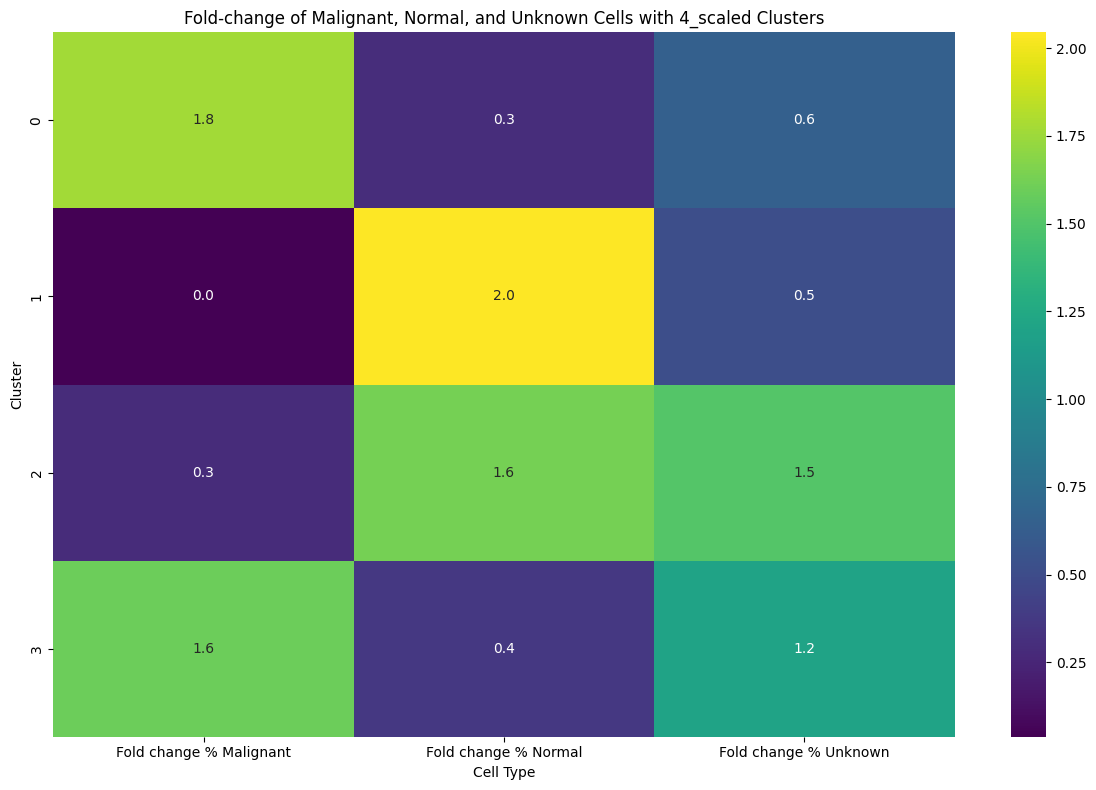

In [33]:
cluster_col = f'cluster_{n_comp}'

# Tabella a doppia entrata tra cluster e predizione del tipo cellulare
crosstab = pd.crosstab(adata.obs[cluster_col], adata.obs['cell_type_prediction'])

# Tabella con conteggio totale e percentuali
cluster_counts = adata.obs.groupby([cluster_col, "cell_type_prediction"]).size().unstack(fill_value=0)
cluster_counts["Total"] = cluster_counts.sum(axis=1)
cluster_counts["Malignant %"] = cluster_counts["Malignant"] / cluster_counts["Total"] * 100
cluster_counts["Normal %"] = cluster_counts["Normal"] / cluster_counts["Total"] * 100
cluster_counts["Unknown %"] = cluster_counts["Unknown"] / cluster_counts["Total"] * 100

# Calcolo del fold-change rispetto alle percentuali complessive nell'intero dataset
cluster_counts["Fold change % Malignant"] = cluster_counts["Malignant %"] / malignant_pct_total
cluster_counts["Fold change % Normal"] = cluster_counts["Normal %"] / normal_pct_total
cluster_counts["Fold change % Unknown"] = cluster_counts["Unknown %"] / unknown_pct_total

# HEATMAP
filename = f"figures/HEATMAP_{cluster_col}.pdf"

plt.figure(figsize=(12, 8))
sns.heatmap(
    cluster_counts[["Fold change % Malignant", "Fold change % Normal", "Fold change % Unknown"]],
    cmap="viridis", annot=True, fmt=".1f")

plt.title(f"Fold-change of Malignant, Normal, and Unknown Cells with {n_comp} Clusters")
plt.xlabel("Cell Type")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig(filename)
plt.show()
plt.close()

# Crea un DataFrame con i cell_id (che sono gli index di adata.obs) e i custer
df_clusters = pd.DataFrame({
    'cell_id': adata.obs_names,             # Index di AnnData corrisponde ai cell ID
    cluster_col: adata.obs[cluster_col].values})

# Salva in CSV
output_path = f"results/cluster_value_{cluster_col}.csv"
df_clusters.to_csv(output_path, index=False)

In [21]:
## DEFINIZIONE DEI CLUSTER
# HISTOLOGICAL_SINGLE_FEATURES_DOWN_UNSCALED
malignant_clusters = [1, 2]
normal_clusters = [3]
unknown_clusters = [0]

In [34]:
# HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED
malignant_clusters = [0, 3]
normal_clusters = [1]
unknown_clusters = [2]

reclassified_cluster_4_scaled
Malignant (original)    25000
Normal (original)       25000
Unknown → Malignant      2078
Unknown (unchanged)      1840
Unknown → Normal          393
Name: count, dtype: int64
['Malignant', 'Unknown', 'Normal']
Categories (3, object): ['Malignant', 'Normal', 'Unknown']


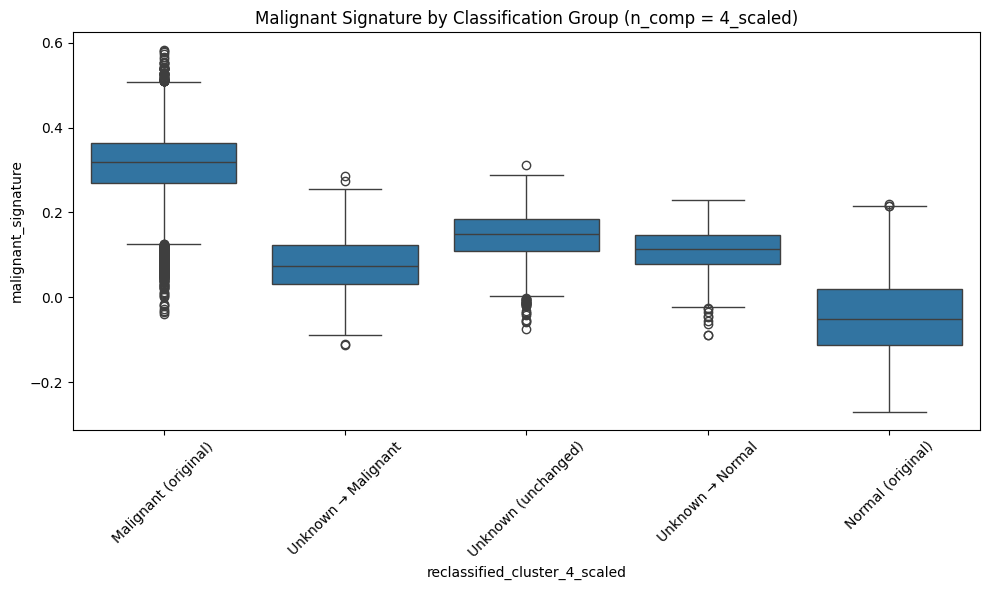

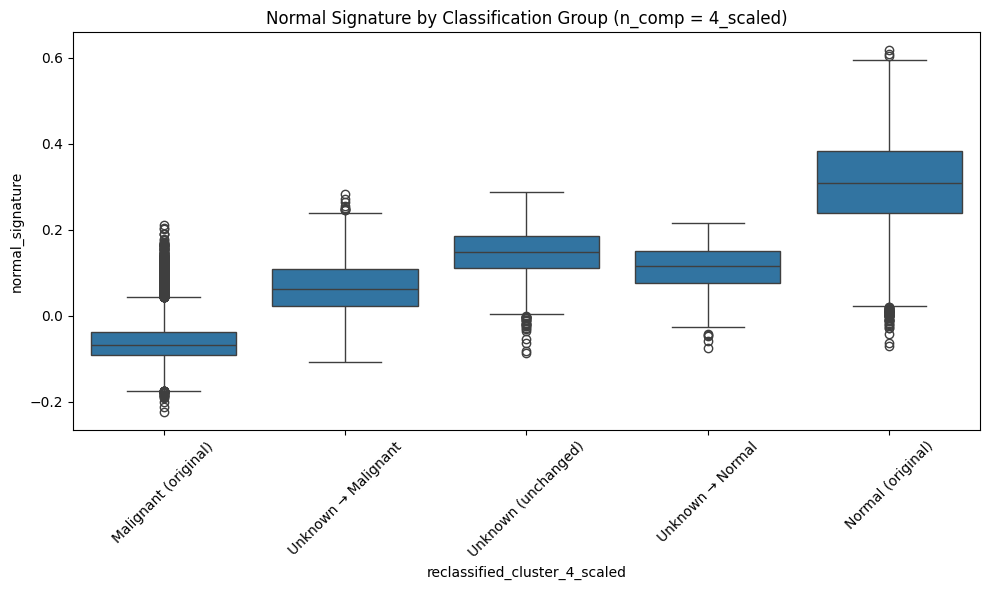

In [35]:
# USO LE SIGNATURE MALIGNANT E NORMAL CHE HO TROVATO CON I DATI MOLECOLARI 
new_cluster_col = f"new_cluster_{n_comp}"   # Classificazione in Normal, Malignant e Unknown basata sul cluster

# Funzione per assegnare etichetta in base al cluster
def assign_cluster_label(cluster):
    if cluster in malignant_clusters:
        return "Malignant"
    elif cluster in normal_clusters:
        return "Normal"
    elif cluster in unknown_clusters:
        return "Unknown"
    else:
        return "Undefined"

# Applicazione funzione
adata.obs[new_cluster_col] = adata.obs[cluster_col].apply(assign_cluster_label)

# Riclassificazione combinata originale vs cluster
def classify_group(row):
    original = row['cell_type_prediction']
    new = row[new_cluster_col]
    if original == 'Malignant':
        return 'Malignant (original)'
    elif original == 'Normal':
        return 'Normal (original)'
    elif original == 'Unknown':
        if new == 'Malignant':
            return 'Unknown → Malignant'
        elif new == 'Normal':
            return 'Unknown → Normal'
        else:
            return 'Unknown (unchanged)'
    else:
        return 'Other'

reclassified_col = f'reclassified_cluster_{n_comp}'
adata.obs[reclassified_col] = adata.obs.apply(classify_group, axis=1)

print(adata.obs[reclassified_col].value_counts())
print(adata.obs['cell_type_prediction'].unique())

# Define plotting order dynamically: keep only groups present in the data
present_groups = adata.obs[reclassified_col].unique().tolist()

order_malignant = [
    g for g in [
        'Malignant (original)',
        'Unknown → Malignant',
        'Unknown (unchanged)',
        'Unknown → Normal',
        'Normal (original)'
    ] if g in present_groups
]
order_normal = order_malignant.copy()

# Boxplot - Malignant Signature
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=adata.obs,
    x=reclassified_col,
    y='malignant_signature',
    order=order_malignant
)
plt.title(f'Malignant Signature by Classification Group (n_comp = {n_comp})')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'figures/AUTOK_Malignant_signature_clusters_{n_comp}.pdf', dpi=300)
plt.show()
plt.close()

# Boxplot - Normal Signature
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=adata.obs,
    x=reclassified_col,
    y='normal_signature',
    order=order_normal
)
plt.title(f'Normal Signature by Classification Group (n_comp = {n_comp})')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'figures/AUTOK_Normal_signature_clusters_{n_comp}.pdf', dpi=300)
plt.show()
plt.close()

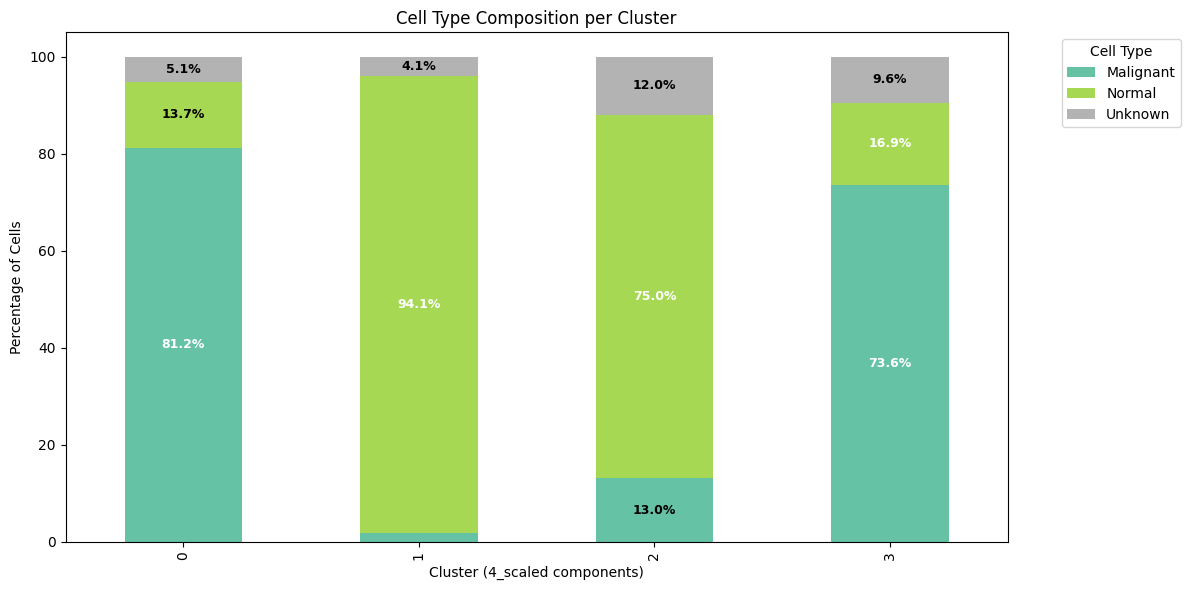

In [36]:
# Ricalcolo se necessario
cluster_col = f'cluster_{n_comp}'
df = adata.obs.copy()

cluster_dist = pd.crosstab(df[cluster_col], df['cell_type_prediction'])
cluster_pct = cluster_dist.div(cluster_dist.sum(axis=1), axis=0) * 100

# Plot
ax = cluster_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='Set2')

# Aggiunte le percentuali sopra le sezioni
for i, cluster in enumerate(cluster_pct.index):
    y_offset = 0
    for cell_type in cluster_pct.columns:
        pct = cluster_pct.loc[cluster, cell_type]
        if pct > 3:  # Visualizza solo se > 3% per evitare sovrapposizioni
            ax.text(
                i,                        # posizione x
                y_offset + pct / 2,       # posizione y (metà del segmento)
                f'{pct:.1f}%',            # testo
                ha='center',
                va='center',
                fontsize=9,
                color='white' if pct > 15 else 'black',
                fontweight='bold')
        y_offset += pct

plt.ylabel('Percentage of Cells')
plt.xlabel(f'Cluster ({n_comp} components)')
plt.title('Cell Type Composition per Cluster')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'figures/StackedBar_celltype_composition_cluster_{n_comp}_labeled.pdf', dpi=300)
plt.show()
plt.close()

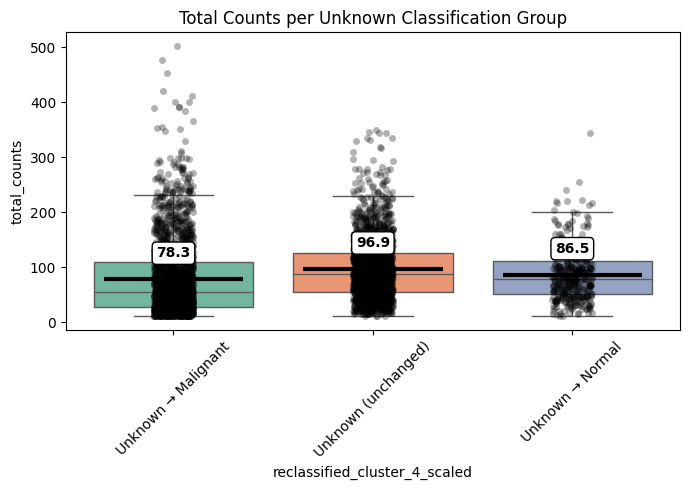

In [37]:
# Column with reclassification
reclassified_col = f'reclassified_cluster_{n_comp}'

# Keep only cells originally classified as Unknown
df_unknown = adata.obs[adata.obs['cell_type_prediction'] == 'Unknown'].copy()

# Groups of interest
plot_order = ['Unknown → Malignant', 'Unknown (unchanged)', 'Unknown → Normal']

# Keep only the valid groups
df_plot = df_unknown[df_unknown[reclassified_col].isin(plot_order)].copy()

# Only keep groups that are actually present
present_groups = [g for g in plot_order if g in df_plot[reclassified_col].unique()]

if len(present_groups) == 0:
    print("No Unknown subgroups present → skipping plot.")
else:
    # Convert column to categorical with correct order
    df_plot[reclassified_col] = pd.Categorical(
        df_plot[reclassified_col],
        categories=present_groups,
        ordered=True)

    def plot_counts(df, x_var, title, palette='Set2', figsize=(7, 5)):
        plt.figure(figsize=figsize)
        ax = sns.boxplot(
            data=df,
            x=x_var,
            y='total_counts',
            palette=palette,
            order=present_groups,
            showfliers=False)

        sns.stripplot(
            data=df,
            x=x_var,
            y='total_counts',
            color='black',
            alpha=0.3,
            jitter=True,
            order=present_groups,
            ax=ax)

        # Add mean values with bold labels
        means = df.groupby(x_var)['total_counts'].mean()
        y_range = df['total_counts'].max() - df['total_counts'].min()

        for i, cat in enumerate(present_groups):
            mean_val = means[cat]
            # Black line for mean
            ax.hlines(mean_val, i - 0.35, i + 0.35, colors='black', linewidth=3)

            # White box with black border for text
            bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

            ax.text(i, mean_val + 0.07 * y_range, f"{mean_val:.1f}",
                    ha='center', va='bottom', fontsize=10, fontweight='bold',
                    color='black', bbox=bbox_props)

        plt.title(title)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Apply plotting function
    plot_counts(
        df_plot,
        x_var=reclassified_col,
        title='Total Counts per Unknown Classification Group',
        palette='Set2')

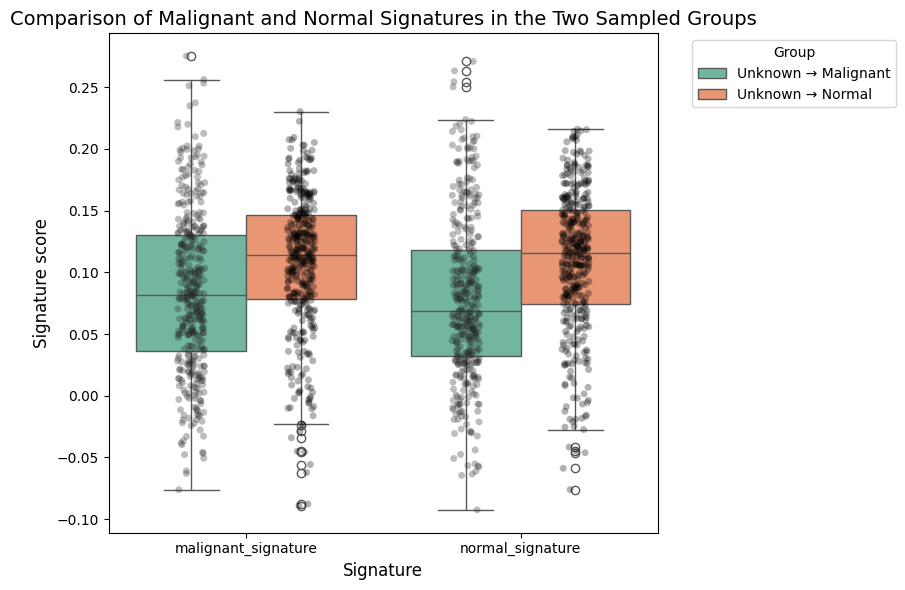


Final proportional distribution by bin - Unknown → Malignant:
count_bin
(10.998000000000001, 12.0]    0.005141
(12.0, 13.0]                  0.002571
(13.0, 13.5]                  0.000000
(13.5, 14.0]                  0.005141
(14.0, 14.55]                 0.000000
                                ...   
(283.5, 296.3]                0.000000
(296.3, 309.375]              0.000000
(309.375, 354.65]             0.002571
(354.65, 398.6]               0.000000
(398.6, 503.0]                0.000000
Name: proportion, Length: 205, dtype: float64

Final proportional distribution by bin - Unknown → Normal:
count_bin
(10.998000000000001, 12.0]    0.005141
(12.0, 13.0]                  0.002571
(13.0, 13.5]                  0.000000
(13.5, 14.0]                  0.005141
(14.0, 14.55]                 0.000000
                                ...   
(283.5, 296.3]                0.000000
(296.3, 309.375]              0.000000
(309.375, 354.65]             0.002571
(354.65, 398.6]               0

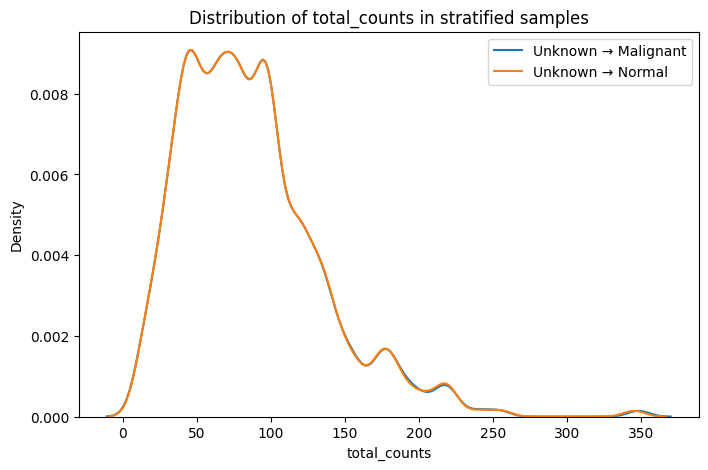

In [38]:
# Confronto U→M e U→N con la stessa distribuzione di total_counts e verificare se le signature cambiano 

# Filtro le cellule dei due gruppi in un unico dataframe
df_unknown = adata.obs[adata.obs[reclassified_col].isin(['Unknown → Malignant', 'Unknown → Normal'])].copy()

# Definisco i bin comuni calcolandoli sull'intero dataframe insieme
n_bins = 400
df_unknown['count_bin'] = pd.qcut(df_unknown['total_counts'], q=n_bins, duplicates='drop')

# Suddivido i gruppi
df_malignant_group = df_unknown[df_unknown[reclassified_col] == 'Unknown → Malignant'].copy()
df_normal_group = df_unknown[df_unknown[reclassified_col] == 'Unknown → Normal'].copy()

def stratified_sample_same_bins_with_print(df_group1, df_group2, n_samples_per_bin=25):
    # Individua bin comuni in cui entrambi hanno almeno 1 cellula
    bins_group1 = set(df_group1['count_bin'].value_counts().index)
    bins_group2 = set(df_group2['count_bin'].value_counts().index)
    common_bins = sorted(list(bins_group1.intersection(bins_group2)))

    samples1 = []
    samples2 = []

    for b in common_bins:
        bin_df1 = df_group1[df_group1['count_bin'] == b]
        bin_df2 = df_group2[df_group2['count_bin'] == b]

        min_count = min(len(bin_df1), len(bin_df2), n_samples_per_bin)
        if min_count == 0:           
            continue
        
        samples1.append(bin_df1.sample(n=min_count, random_state=42))
        samples2.append(bin_df2.sample(n=min_count, random_state=42))

    sampled_df1 = pd.concat(samples1).drop(columns='count_bin')
    sampled_df2 = pd.concat(samples2).drop(columns='count_bin')

    return sampled_df1, sampled_df2, common_bins

# Campiono
sampled_malignant, sampled_normal, common_bins = stratified_sample_same_bins_with_print(df_malignant_group, df_normal_group, n_samples_per_bin=25)

# Estraggo gli indici campionati
cells_malignant = sampled_malignant.index.tolist()
cells_normal = sampled_normal.index.tolist()

# Preparo dataframe per confronto firme
df_malignant = adata.obs.loc[cells_malignant, ['malignant_signature', 'normal_signature']].copy()
df_malignant['group'] = 'Unknown → Malignant'

df_normal = adata.obs.loc[cells_normal, ['malignant_signature', 'normal_signature']].copy()
df_normal['group'] = 'Unknown → Normal'

df_compare = pd.concat([df_malignant, df_normal])
df_long = df_compare.melt(id_vars='group', var_name='signature', value_name='score')

plt.figure(figsize=(9, 6))
sns.boxplot(data=df_long, x='signature', y='score', hue='group', palette='Set2')
sns.stripplot(data=df_long, x='signature', y='score', hue='group', dodge=True, color='black', alpha=0.3, jitter=True, legend=False)

plt.title("Comparison of Malignant and Normal Signatures in the Two Sampled Groups", fontsize=14)
plt.ylabel("Signature score", fontsize=12)
plt.xlabel("Signature", fontsize=12)
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Aggiungo i total_counts ai campioni
sampled_malignant = sampled_malignant.assign(total_counts=adata.obs.loc[sampled_malignant.index, 'total_counts'])
sampled_normal = sampled_normal.assign(total_counts=adata.obs.loc[sampled_normal.index, 'total_counts'])

# Ricreo i bin sui campioni usando gli intervalli originali
# Ottiengo gli estremi degli intervalli dai bin comuni (sono pd.Interval)
bin_edges = [common_bins[0].left] + [interval.right for interval in common_bins]

sampled_malignant['count_bin'] = pd.cut(sampled_malignant['total_counts'], bins=bin_edges, include_lowest=True)
sampled_normal['count_bin'] = pd.cut(sampled_normal['total_counts'], bins=bin_edges, include_lowest=True)

# Stampo distribuzione proporzionale per bin
print("\nFinal proportional distribution by bin - Unknown → Malignant:")
print(sampled_malignant['count_bin'].value_counts(normalize=True).sort_index())

print("\nFinal proportional distribution by bin - Unknown → Normal:")
print(sampled_normal['count_bin'].value_counts(normalize=True).sort_index())

# Plot KDE delle distribuzioni di total_counts
plt.figure(figsize=(8,5))
sns.kdeplot(sampled_malignant['total_counts'], label='Unknown → Malignant', bw_adjust=0.5)
sns.kdeplot(sampled_normal['total_counts'], label='Unknown → Normal', bw_adjust=0.5)
plt.title('Distribution of total_counts in stratified samples')
plt.xlabel('total_counts')
plt.ylabel('Density')
plt.legend()
plt.show()

In [26]:
def normalize_and_log(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

normalize_and_log(adata_histological_single_features_down)


 Running DGE: Unknown_to_Malignant_vs_Malignant (n=27078)
CSV saved: results/DGE/DGE_Unknown_to_Malignant_vs_Malignant.csv


<Figure size 800x600 with 0 Axes>

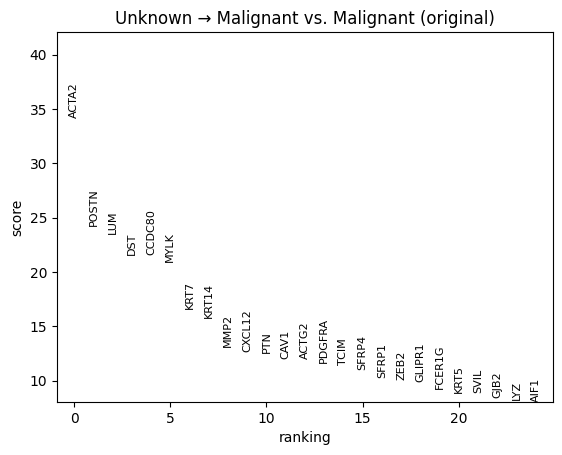

Rank genes plot saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Malignant_vs_Malignant.pdf


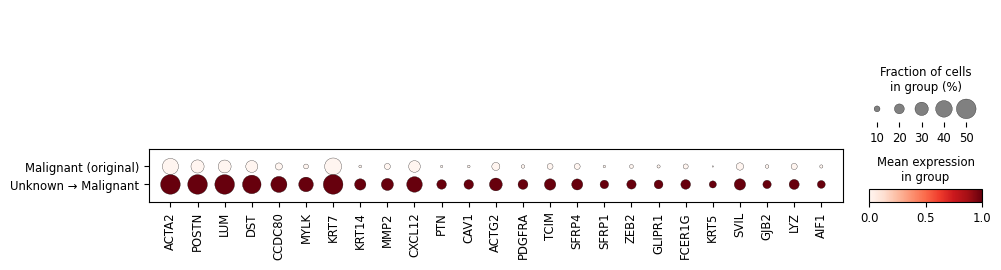

Dotplot saved for Unknown_to_Malignant_vs_Malignant

 Running DGE: Unknown_(unchanged)_vs_Malignant (n=26840)
CSV saved: results/DGE/DGE_Unknown_(unchanged)_vs_Malignant.csv


<Figure size 800x600 with 0 Axes>

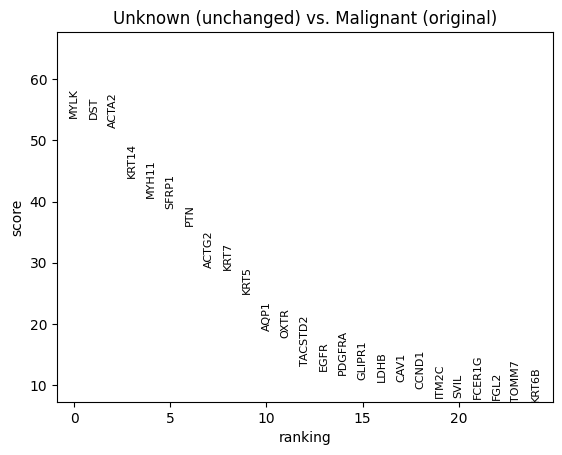

Rank genes plot saved: figures/DGE_rank_genes/RankGenes_Unknown_(unchanged)_vs_Malignant.pdf


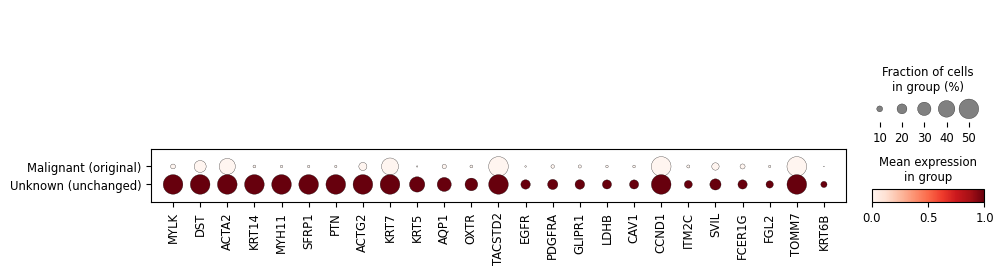

Dotplot saved for Unknown_(unchanged)_vs_Malignant

 Running DGE: Unknown_to_Normal_vs_Malignant (n=25393)
CSV saved: results/DGE/DGE_Unknown_to_Normal_vs_Malignant.csv


<Figure size 800x600 with 0 Axes>

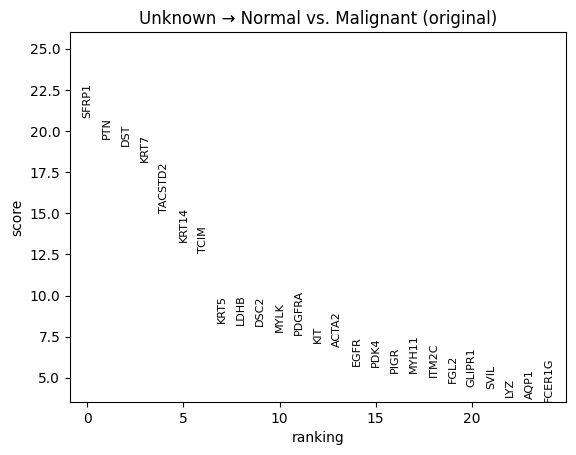

Rank genes plot saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Normal_vs_Malignant.pdf


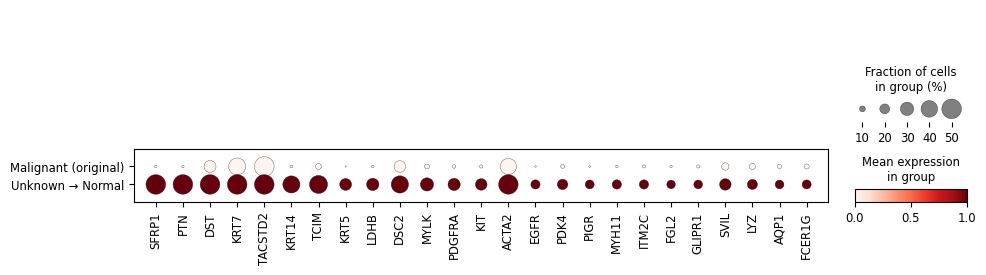

Dotplot saved for Unknown_to_Normal_vs_Malignant

 Running DGE: Unknown_to_Malignant_vs_Normal (n=27078)
CSV saved: results/DGE/DGE_Unknown_to_Malignant_vs_Normal.csv


<Figure size 800x600 with 0 Axes>

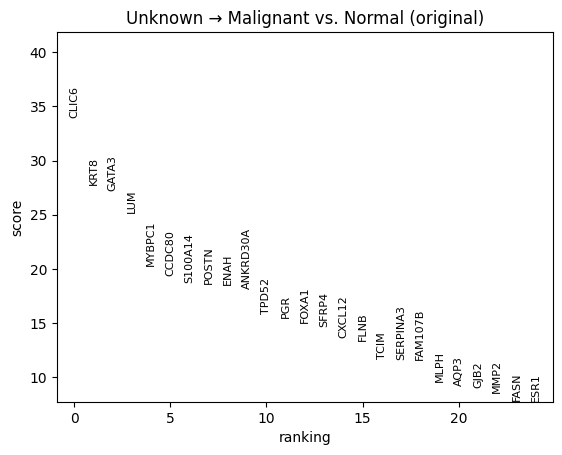

Rank genes plot saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Malignant_vs_Normal.pdf


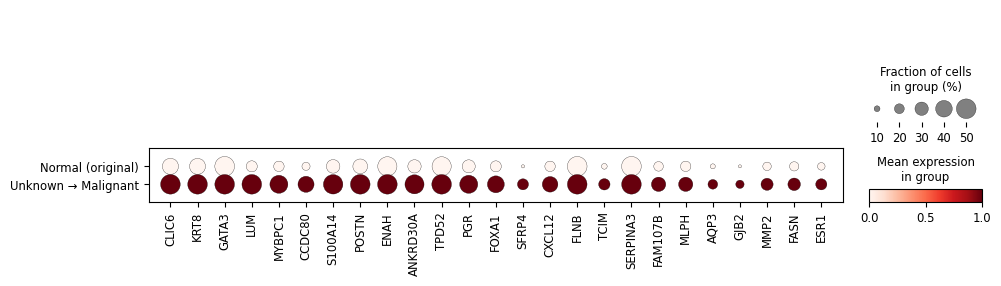

Dotplot saved for Unknown_to_Malignant_vs_Normal

 Running DGE: Unknown_(unchanged)_vs_Normal (n=26840)
CSV saved: results/DGE/DGE_Unknown_(unchanged)_vs_Normal.csv


<Figure size 800x600 with 0 Axes>

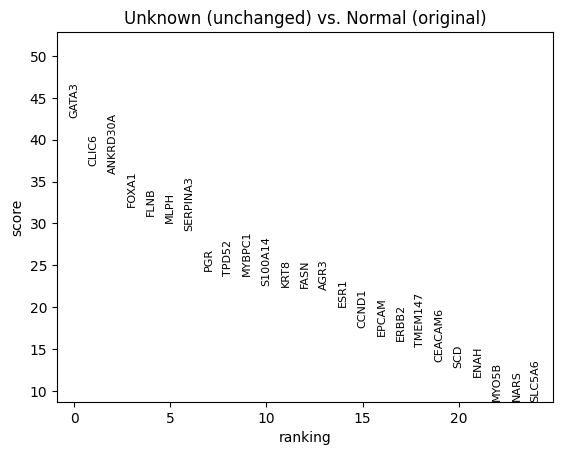

Rank genes plot saved: figures/DGE_rank_genes/RankGenes_Unknown_(unchanged)_vs_Normal.pdf


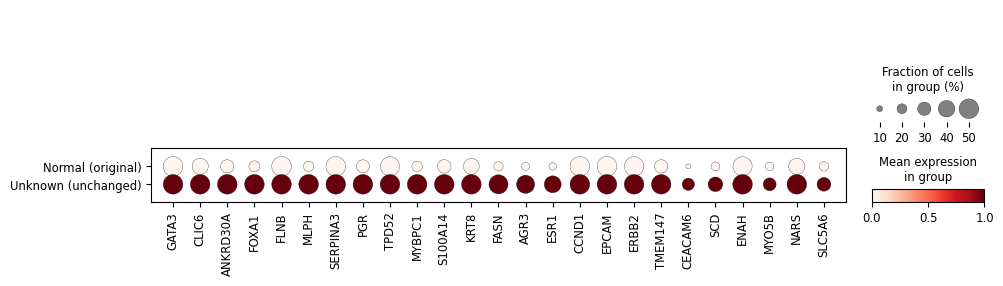

Dotplot saved for Unknown_(unchanged)_vs_Normal

 Running DGE: Unknown_to_Normal_vs_Normal (n=25393)
CSV saved: results/DGE/DGE_Unknown_to_Normal_vs_Normal.csv


<Figure size 800x600 with 0 Axes>

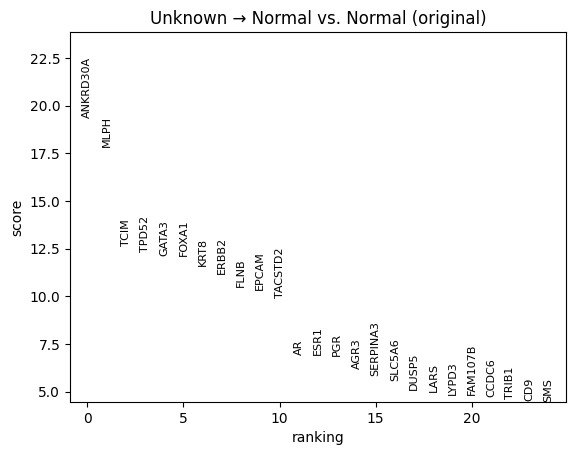

Rank genes plot saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Normal_vs_Normal.pdf


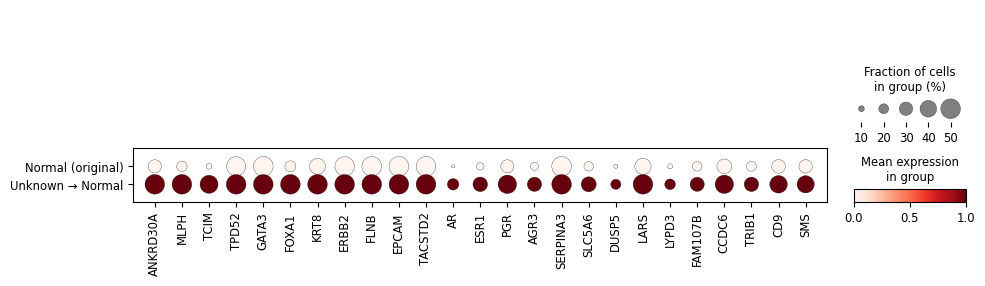

Dotplot saved for Unknown_to_Normal_vs_Normal


In [39]:
# Esegue DGE e genera rank_genes_groups plot + dotplot per tutti i contrasti tra Unknown e reference

# Parametri principali
reclassified_col = f'reclassified_cluster_{n_comp}'
celltype_col = 'cell_type_prediction'
unknown_subgroups = ['Unknown → Malignant', 'Unknown (unchanged)', 'Unknown → Normal']
references = ['Malignant', 'Normal']

# Cartelle output
os.makedirs('results/DGE', exist_ok=True)
os.makedirs('figures/DGE_rank_genes', exist_ok=True)
os.makedirs('figures/DGE_dotplot', exist_ok=True)

def run_dge_and_dotplots(
    adata, 
    reclassified_col, 
    celltype_col, 
    unknown_subgroups, 
    references, 
    top_n_genes=25):

    for ref in references:
        for unk_group in unknown_subgroups:
            contrast_name = f"{unk_group.replace(' ', '_').replace('→', 'to')}_vs_{ref}"

            # Filtra le celle coinvolte
            cells_condition = (
                (adata.obs[reclassified_col] == unk_group) |
                (adata.obs[celltype_col] == ref))
            sub_adata = adata[cells_condition].copy()

            # Colonna temporanea per i gruppi
            sub_adata.obs['dge_group'] = sub_adata.obs[reclassified_col].where(
                sub_adata.obs[reclassified_col] == unk_group,
                f"{ref} (original)")

            print(f"\n Running DGE: {contrast_name} (n={sub_adata.n_obs})")

            # DGE con Wilcoxon
            sc.tl.rank_genes_groups(sub_adata, groupby='dge_group', reference=f"{ref} (original)", method='wilcoxon')
            res = sub_adata.uns['rank_genes_groups']
            group = [g for g in res['names'].dtype.names if g != f"{ref} (original)"][0]

            # Salva CSV dei risultati
            dge_df = pd.DataFrame({
                'gene': res['names'][group],
                'logfoldchange': res['logfoldchanges'][group],
                'pval': res['pvals'][group],
                'pval_adj': res['pvals_adj'][group]
            }).sort_values('pval_adj')
            dge_csv_path = f"results/DGE/DGE_{contrast_name}.csv"
            dge_df.to_csv(dge_csv_path, index=False)
            print(f"CSV saved: {dge_csv_path}")

            # --- Rank genes plot ---
            plt.figure(figsize=(8,6))
            sc.pl.rank_genes_groups(
                sub_adata,
                n_genes=top_n_genes,
                sharey=False,
                show=True,  # Mostra a schermo
                use_raw=False,
                title=f"{unk_group} vs {ref}")
            plt.tight_layout()
            rank_plot_path = f"figures/DGE_rank_genes/RankGenes_{contrast_name}.pdf"
            plt.savefig(rank_plot_path, dpi=300)
            plt.close()
            print(f"Rank genes plot saved: {rank_plot_path}")

            # --- Dotplot ---
            top_genes = pd.Series(res['names'][group]).dropna().head(top_n_genes).tolist()
            if len(top_genes) == 0:
                print(f"No top genes found for {contrast_name}, skipping dotplot.")
                continue

            sc.pl.dotplot(
                sub_adata,
                var_names=top_genes,
                groupby='dge_group',
                standard_scale='var',
                dot_max=0.5,
                color_map='Reds',
                show=True,  # Mostra a schermo
                save=f"{contrast_name}.pdf")
            print(f"Dotplot saved for {contrast_name}")

# Esegui la funzione
run_dge_and_dotplots(adata, reclassified_col, celltype_col, unknown_subgroups, references, top_n_genes=25)

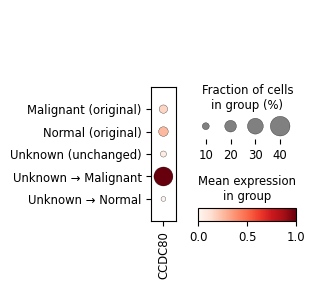

In [40]:
sc.pl.dotplot(
    adata,
    var_names=['CCDC80'],
    groupby=reclassified_col,  
    standard_scale='var',
    color_map='Reds',
    show=True)

In [41]:
# Estraggo espressione del gene e la inserisci come colonna in obs
adata.obs['CCDC80_expr_scaled'] = adata[:, 'CCDC80'].X.toarray().flatten()

# Raggruppo per gruppo di classificazione e calcola la media
adata.obs.groupby(reclassified_col)['CCDC80_expr_scaled'].mean().sort_values(ascending=False)

reclassified_cluster_4_scaled
Unknown → Malignant     2.112472
Normal (original)       0.759390
Malignant (original)    0.592719
Unknown (unchanged)     0.401410
Unknown → Normal        0.298550
Name: CCDC80_expr_scaled, dtype: float32

In [42]:
# Creo la nuova colonna con la classificazione finale delle cellule 
adata.obs['final_labels_scaled'] = adata.obs[reclassified_col].apply(
    lambda x: 'Malignant' if x in ['Malignant (original)', 'Unknown → Malignant'] 
             else 'Normal' if x in ['Normal (original)', 'Unknown → Normal'] 
             else 'Unknown' if x == 'Unknown (unchanged)' 
             else x)

print(adata.obs['final_labels_scaled'].value_counts())

final_labels_scaled
Malignant    27078
Normal       25393
Unknown       1840
Name: count, dtype: int64


In [43]:
def preprocess_and_umap(adata, rep_name, cluster_col, title):
    sc.pp.neighbors(adata, use_rep=rep_name)
    sc.tl.umap(adata)
    sc.pl.umap(
        adata, 
        color=cluster_col, 
        title=title, 
        palette="tab10", 
        legend_loc="right margin")

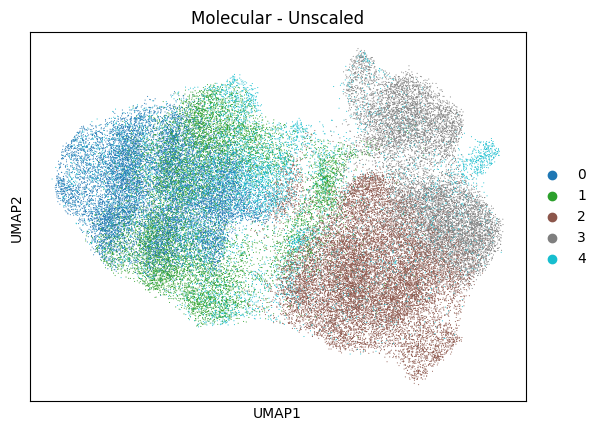

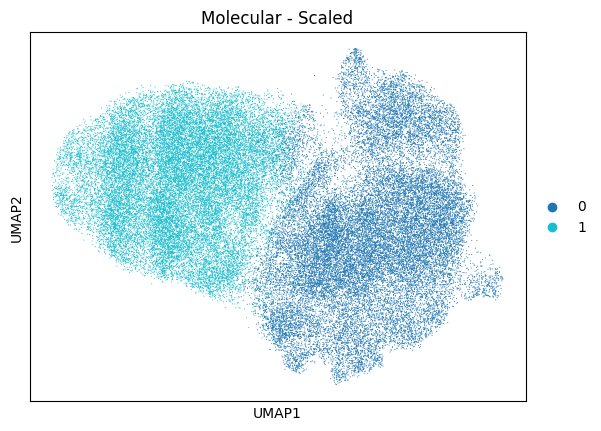

In [44]:
# Unscaled
preprocess_and_umap(
    adata_molecular_single_features_down,
    rep_name="molecular_single_features",
    cluster_col="cluster_5_unscaled",
    title="Molecular - Unscaled")

# Scaled
preprocess_and_umap(
    adata_molecular_single_features_down,
    rep_name="molecular_single_features_scaled",
    cluster_col="cluster_2_scaled",
    title="Molecular - Scaled")

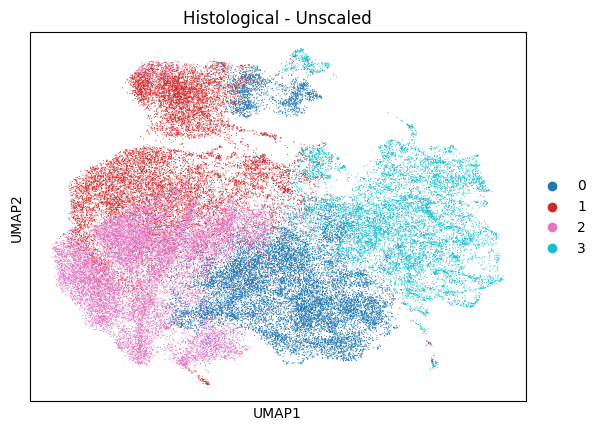

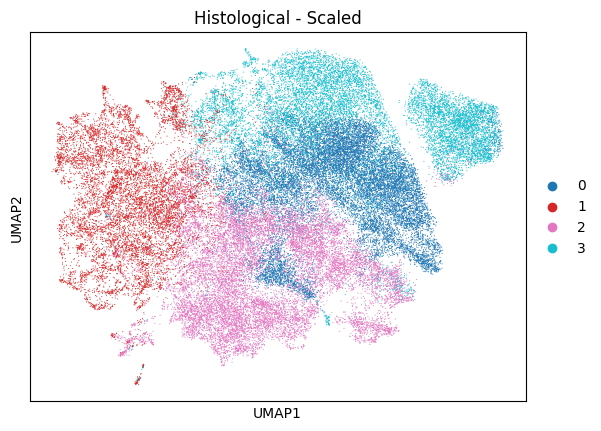

In [45]:
# Unscaled
preprocess_and_umap(
    adata_histological_single_features_down,
    rep_name="histological_single_features",
    cluster_col="cluster_4_unscaled",
    title="Histological - Unscaled")

# Scaled
preprocess_and_umap(
    adata_histological_single_features_down,
    rep_name="histological_single_features_scaled",
    cluster_col="cluster_4_scaled",
    title="Histological - Scaled")

In [46]:
# Funzione per applicare GMM clustering (default k=2) sulle single features

def run_gmm_clustering_on_features(
    adata,
    feature_key: str,
    cluster_key: str = 'GMM_clusters',
    n_components: int = 2,
    random_state: int = 42,
    compute_umap: bool = True):

    # 1. Estraggo le feature
    X = adata.obsm[feature_key]

    # 2. Applico GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state)
    clusters = gmm.fit_predict(X)

    # 3. Salvo i cluster in obs
    adata.obs[cluster_key] = clusters.astype(str)  # salva come stringa per compatibilità grafici
    adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")

    # 4. Calcolo neighbors + UMAP
    if compute_umap:
        sc.pp.neighbors(adata, use_rep=feature_key)
        sc.tl.umap(adata)

    print(f"GMM clustering con {n_components} cluster salvato in adata.obs['{cluster_key}']")

In [47]:
# MOLECULAR SINGLE FEATURES DOWN SCALED
run_gmm_clustering_on_features(
    adata=adata_molecular_single_features_down,
    feature_key='molecular_single_features_scaled',
    cluster_key='GMM_clusters')

# HISTOLOGICAL SINGLE FEATURES DOWN SCALED
run_gmm_clustering_on_features(
    adata=adata_histological_single_features_down,
    feature_key='histological_single_features_scaled',
    cluster_key='GMM_clusters')

GMM clustering con 2 cluster salvato in adata.obs['GMM_clusters']
GMM clustering con 2 cluster salvato in adata.obs['GMM_clusters']


In [48]:
# Funzione per plottare due UMAP side-by-side:     - sinistra: GMM clustering     - destra: predizione del tipo cellulare (cell_type_prediction)

def plot_umap_gmm_vs_celltype(
    adata,
    cluster_key='GMM_clusters',
    cluster_palette=['blue', 'red'],
    celltype_palette={'Normal': 'blue', 'Malignant': 'red', 'Unknown': 'black'},
    title_left='GMM Clustering (k=2)',
    title_right='Cell Type Prediction',
    figsize=(12, 5),
    save_path=None):

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # GMM Clustering
    sc.pl.umap(
        adata,
        color=cluster_key,
        palette=cluster_palette,
        title=title_left,
        ax=axes[0],
        show=False    )

    # Cell Type Prediction
    sc.pl.umap(
        adata,
        color='cell_type_prediction',
        palette=celltype_palette,
        title=title_right,
        ax=axes[1],
        show=False    )

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()

In [49]:
# FUNZIONE per plottare due UMAP affiancati: a sinistra GMM clustering con Unknown evidenziate, a destra solo Unknown in rosso.

def plot_gmm_vs_unknown_highlight(
    adata,
    cluster_key: str = 'GMM_clusters',
    title_left: str = 'GMM clustering of Unknown cells (highlighted)',
    title_right: str = 'Cell Type Prediction (highlight Unknown)',
    cluster_palette: list = ['blue', 'red'],
    save_path: str = None):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Maschere
    mask_known = adata.obs['cell_type_prediction'].isin(['Normal', 'Malignant'])
    mask_unknown = adata.obs['cell_type_prediction'] == 'Unknown'

    sc.pl.umap(
        adata[mask_known],
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray'},
        size=10,
        alpha=0.3,
        ax=axes[0],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color=cluster_key,
        palette=cluster_palette,
        size=10,
        alpha=0.6,
        ax=axes[0],
        show=False,
        legend_loc='right')
    axes[0].set_title(title_left)

    sc.pl.umap(
        adata,
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray', 'Unknown': 'lightgray'},
        size=10,
        alpha=0.5,
        ax=axes[1],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color='cell_type_prediction',
        palette={'Unknown': 'red'},
        size=10,
        alpha=0.6,
        ax=axes[1],
        show=False)
    axes[1].set_title(title_right)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()

In [50]:
# Funzione per plottare un barplot che mostra come le cellule Unknown sono state classificate dai cluster GMM.

def plot_gmm_classification_of_unknowns(
    adata,
    cluster_col: str,
    cell_type_col: str = 'cell_type_prediction',
    unknown_label: str = 'Unknown',
    cluster_label_map: dict = None,
    palette: list = ['blue', 'red'],
    title: str = 'GMM Classification of Unknown Cell Types',
    save_path: str = None):
   
    unknown_cells = adata[adata.obs[cell_type_col] == unknown_label]

    # Converto il tipo in int (se possibile)
    cluster_data = unknown_cells.obs[cluster_col].copy()
    try:
        cluster_data = cluster_data.astype(int)
    except (ValueError, TypeError):
        pass

    if cluster_label_map is not None:
        cluster_data_mapped = cluster_data.map(cluster_label_map)
    else:
        cluster_data_mapped = cluster_data

    df_plot = pd.DataFrame({'gmm_cluster_label': cluster_data_mapped})

    # Imposto ordine desiderato (Malignant a destra)
    desired_order = ['Malignant', 'Normal']
    desired_palette = {'Malignant': 'red', 'Normal': 'blue'}

    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=df_plot, x='gmm_cluster_label',
                       order=desired_order, palette=desired_palette)

    plt.ylabel('Number of Unknown Cells')
    plt.title(title)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 1,
                int(height), ha="center", fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

cell_type_prediction  Malignant  Normal  Unknown
GMM_clusters                                    
0                         24557     250     1370
1                           443   24750     2941


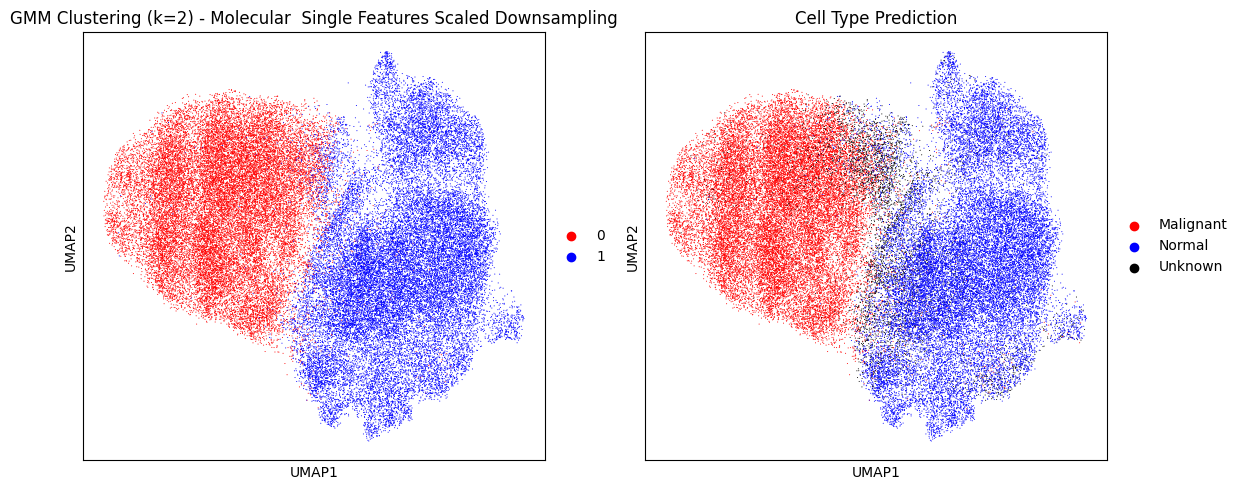

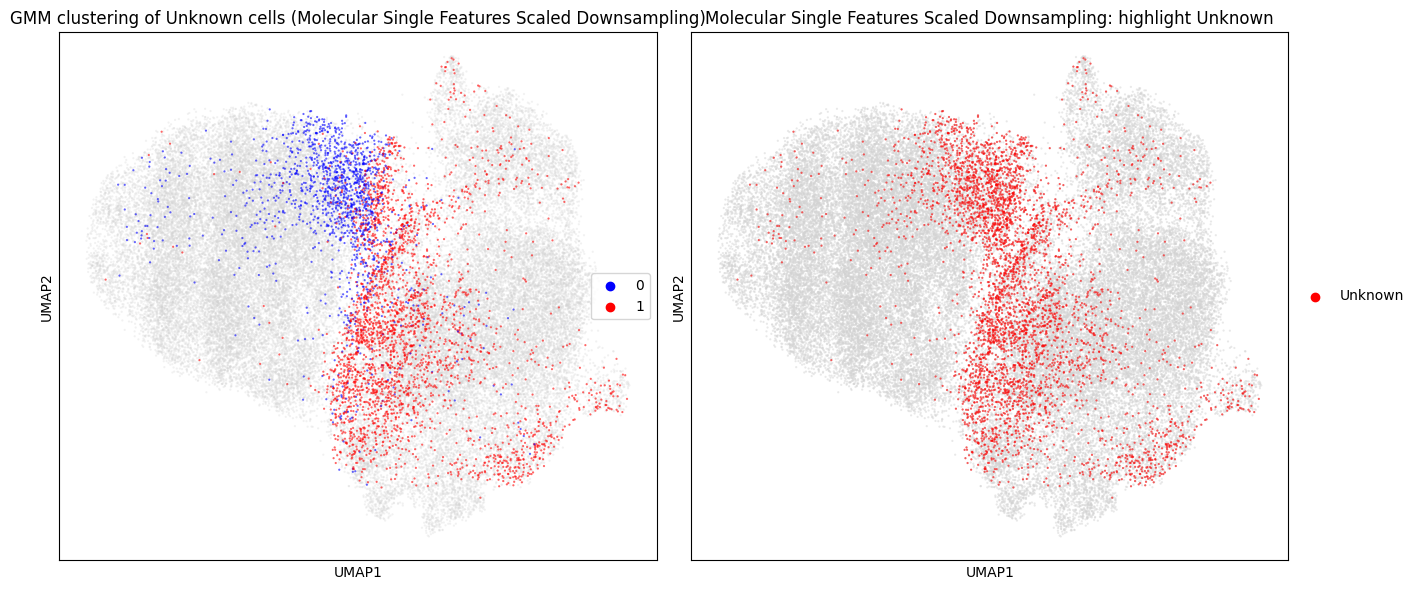

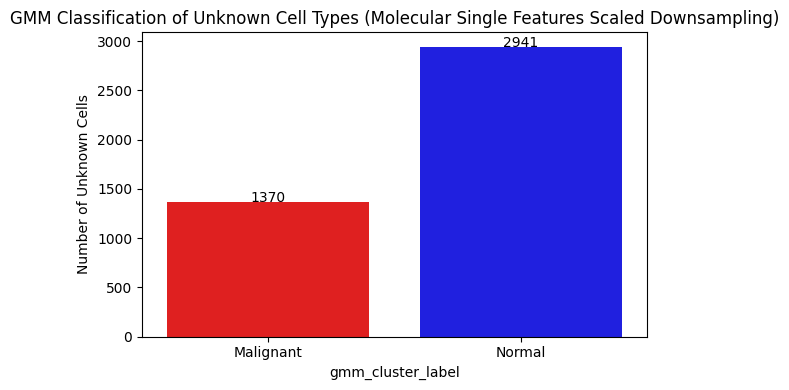

In [51]:
# VISUALIZZAZIONE DI MOLECULAR SINGLE FEATURES DOWN
adata_molecular_single_features_down.obs["GMM_clusters"].value_counts()
print(pd.crosstab(
    adata_molecular_single_features_down.obs["GMM_clusters"],
    adata_molecular_single_features_down.obs["cell_type_prediction"]))

plot_umap_gmm_vs_celltype(
    adata=adata_molecular_single_features_down,
    cluster_key='GMM_clusters',
    cluster_palette=['red', 'blue'],
    celltype_palette={'Normal': 'blue', 'Malignant': 'red', 'Unknown': 'black'},
    title_left='GMM Clustering (k=2) - Molecular  Single Features Scaled Downsampling',
    title_right='Cell Type Prediction',
    save_path='figures/umap_gmm_vs_celltype_molecular_single_features_down_scaled.png')

plot_gmm_vs_unknown_highlight(
    adata=adata_molecular_single_features_down,
    cluster_key='GMM_clusters',
    title_left='GMM clustering of Unknown cells (Molecular Single Features Scaled Downsampling)',
    title_right='Molecular Single Features Scaled Downsampling: highlight Unknown',
    save_path='figures/umap_molecular_single_features_down_scaled_gmm_vs_unknown.png')

plot_gmm_classification_of_unknowns(
    adata=adata_molecular_single_features_down,
    cluster_col='GMM_clusters',
    cell_type_col='cell_type_prediction',
    unknown_label='Unknown',
    cluster_label_map={0: 'Malignant', 1: 'Normal'},
    palette=['red', 'blue'],
    title='GMM Classification of Unknown Cell Types (Molecular Single Features Scaled Downsampling)',
    save_path='figures/barplot_gmm_molecular_single_features_down_scaled_unknowns.png')

In [52]:
# Estrai le etichette predette dai cluster GMM (converti in int se sono categorie)
pred_labels = adata_molecular_single_features_down.obs["GMM_clusters"].astype(int)

# Estrai le etichette vere (ad esempio da 'cell_type_prediction')
# Nota: devi assicurarti che siano codificate come numeri o mappate a valori numerici
true_labels = adata_molecular_single_features_down.obs["cell_type_prediction"]

# Se 'cell_type_prediction' è una stringa, convertila in numeri con una mappa
label_map = {'Malignant': 0, 'Normal': 1, 'Unknown': 2}
true_labels_num = true_labels.map(label_map)

# Calcola ARI
ari_score = adjusted_rand_score(true_labels_num, pred_labels)
print(f"Adjusted Rand Index (ARI) between GMM clusters and true labels: {ari_score:.4f}")

Adjusted Rand Index (ARI) between GMM clusters and true labels: 0.8017


cell_type_prediction  Malignant  Normal  Unknown
GMM_clusters                                    
0                         21257    3043     1733
1                          3743   21957     2578


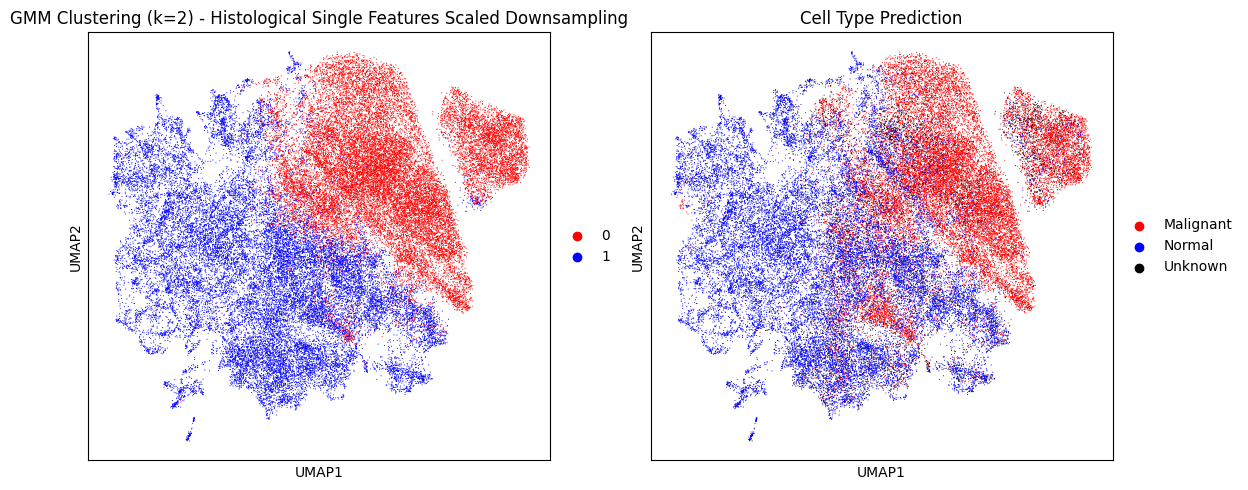

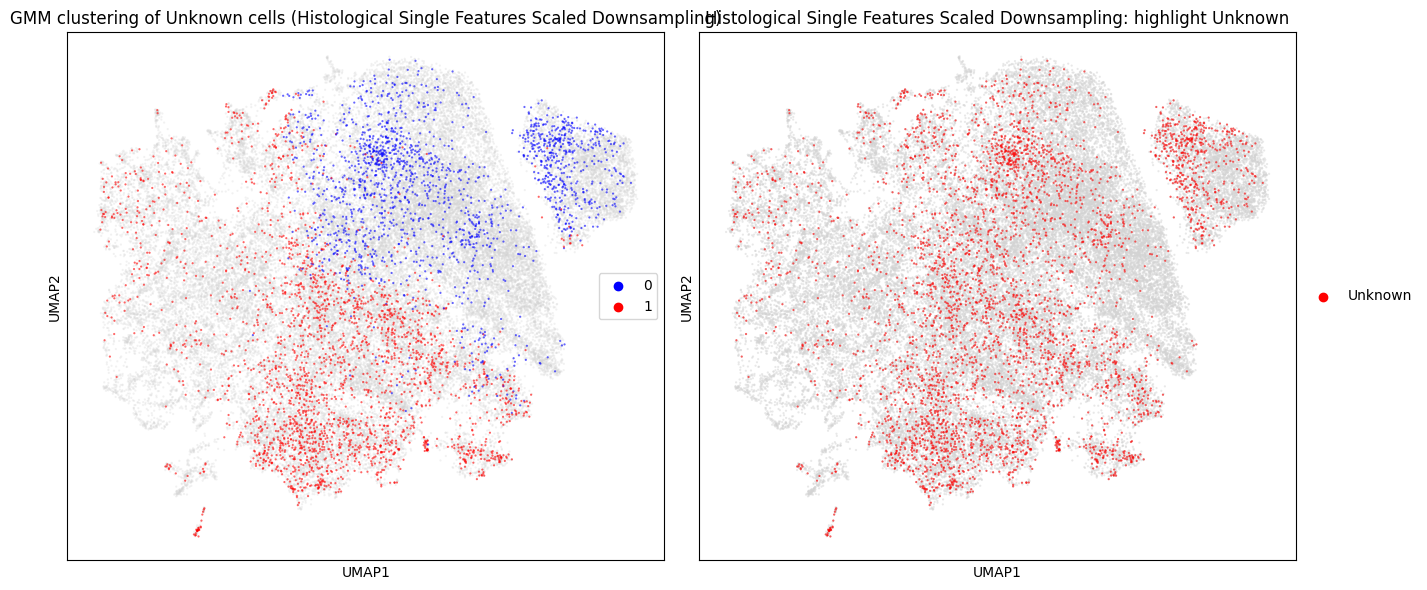

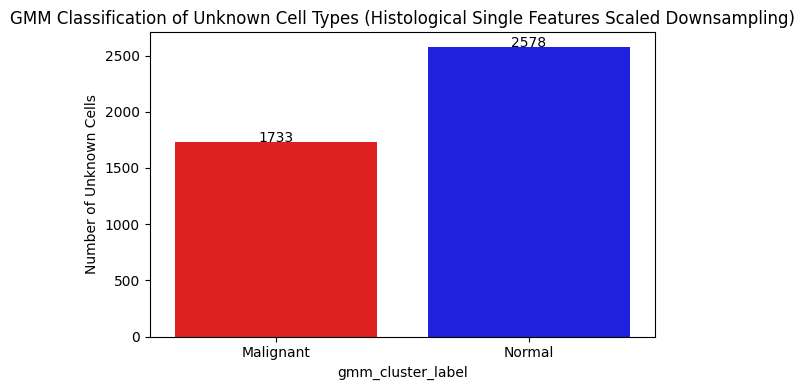

In [53]:
# VISUALIZZAZIONE DI HISTOLOGICAL SINGLE FEATURES DOWNSAMPLING
adata_histological_single_features_down.obs["GMM_clusters"].value_counts()
print(pd.crosstab(
    adata_histological_single_features_down.obs["GMM_clusters"],
    adata_histological_single_features_down.obs["cell_type_prediction"]))

plot_umap_gmm_vs_celltype(
    adata=adata_histological_single_features_down,
    cluster_key='GMM_clusters',
    cluster_palette=['red', 'blue'],
    celltype_palette={'Normal': 'blue', 'Malignant': 'red', 'Unknown': 'black'},
    title_left='GMM Clustering (k=2) - Histological Single Features Scaled Downsampling',
    title_right='Cell Type Prediction',
    save_path='figures/umap_gmm_vs_celltype_histological_single_features_down_scaled.png')

plot_gmm_vs_unknown_highlight(
    adata=adata_histological_single_features_down,
    cluster_key='GMM_clusters',
    title_left='GMM clustering of Unknown cells (Histological Single Features Scaled Downsampling)',
    title_right='Histological Single Features Scaled Downsampling: highlight Unknown',
    save_path='figures/umap_histological_single_features_down_scaled_gmm_vs_unknown.png')

plot_gmm_classification_of_unknowns(
    adata=adata_histological_single_features_down,
    cluster_col='GMM_clusters',
    cell_type_col='cell_type_prediction',
    unknown_label='Unknown',
    cluster_label_map={0: 'Malignant', 1: 'Normal'},
    palette=['red', 'blue'],
    title='GMM Classification of Unknown Cell Types (Histological Single Features Scaled Downsampling)',
    save_path='figures/barplot_gmm_histological_single_features_down_scaled_unknowns.png')

In [54]:
# Estrai le etichette predette dai cluster GMM (converti in int se sono categorie)
pred_labels = adata_histological_single_features_down.obs["GMM_clusters"].astype(int)

# Estrai le etichette vere (ad esempio da 'cell_type_prediction')
# Nota: devi assicurarti che siano codificate come numeri o mappate a valori numerici
true_labels = adata_histological_single_features_down.obs["cell_type_prediction"]

# Se 'cell_type_prediction' è una stringa, convertila in numeri con una mappa
label_map = {'Malignant': 0, 'Normal': 1, 'Unknown': 2}
true_labels_num = true_labels.map(label_map)

# Calcola ARI
ari_score = adjusted_rand_score(true_labels_num, pred_labels)
print(f"Adjusted Rand Index (ARI) between GMM clusters and true labels: {ari_score:.4f}")

Adjusted Rand Index (ARI) between GMM clusters and true labels: 0.4494


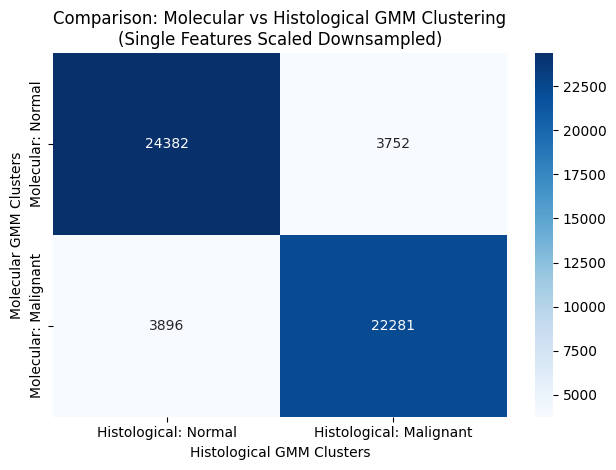

In [55]:
# Confusion matrix tra molecola single feature scaled down e histological single features scaled down

# 1. Trova i nomi delle cellule in comune
common_cells = adata_molecular_single_features_down.obs_names.intersection(
    adata_histological_single_features_down.obs_names)

# 2. Filtra entrambi i dataset
mol_aligned = adata_molecular_single_features_down[common_cells].copy()
hist_aligned = adata_histological_single_features_down[common_cells].copy()

# 3. Verifica che i nomi siano allineati
assert all(mol_aligned.obs_names == hist_aligned.obs_names)

# 4. Estrai le etichette dei cluster allineati e mappa in 'Normal' / 'Malignant'
cluster_label_map = {'0': 'Malignant', '1': 'Normal'}

gmm_mol = mol_aligned.obs["GMM_clusters"].map(cluster_label_map)
gmm_hist = hist_aligned.obs["GMM_clusters"].map(cluster_label_map)

# 5. Confusion matrix
conf_mat = confusion_matrix(
    gmm_mol,
    gmm_hist,
    labels=['Normal', 'Malignant'])

# 6. Visualizza
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Histological: Normal', 'Histological: Malignant'],
            yticklabels=['Molecular: Normal', 'Molecular: Malignant'])
plt.xlabel('Histological GMM Clusters')
plt.ylabel('Molecular GMM Clusters')
plt.title('Comparison: Molecular vs Histological GMM Clustering\n(Single Features Scaled Downsampled)')
plt.tight_layout()
plt.show()

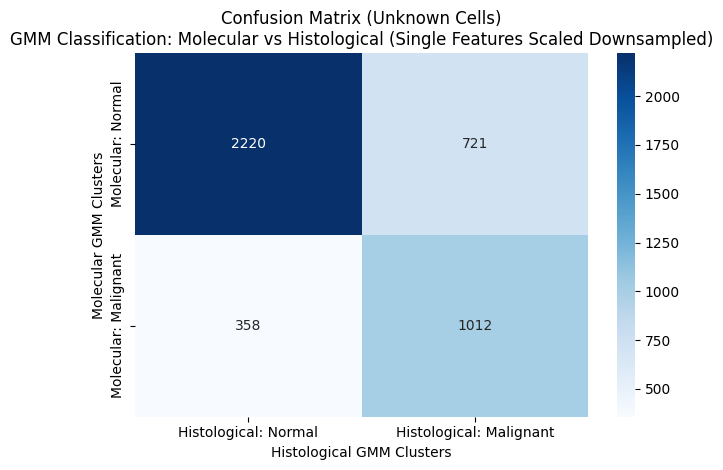

In [56]:
# Confusion matrix delle cellule 'Unknown' in entrambi i dataset
unknown_mol = adata_molecular_single_features_down.obs_names[
    adata_molecular_single_features_down.obs['cell_type_prediction'] == 'Unknown']

unknown_hist = adata_histological_single_features_down.obs_names[
    adata_histological_single_features_down.obs['cell_type_prediction'] == 'Unknown']

# Intersezione: solo le cellule Unknown presenti in entrambi
common_unknown = unknown_mol.intersection(unknown_hist)

mol_unknown = adata_molecular_single_features_down[common_unknown].copy()
hist_unknown = adata_histological_single_features_down[common_unknown].copy()

# Verifica allineamento perfetto
assert all(mol_unknown.obs_names == hist_unknown.obs_names)

cluster_label_map_mol = {'0': 'Malignant', '1': 'Normal'}

gmm_mol = mol_unknown.obs["GMM_clusters"].map(cluster_label_map)
gmm_hist = hist_unknown.obs["GMM_clusters"].map(cluster_label_map)

conf_mat = confusion_matrix(
    gmm_mol,
    gmm_hist,
    labels=['Normal', 'Malignant'])

sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Histological: Normal', 'Histological: Malignant'],
    yticklabels=['Molecular: Normal', 'Molecular: Malignant'])

plt.title('Confusion Matrix (Unknown Cells)\nGMM Classification: Molecular vs Histological (Single Features Scaled Downsampled)')
plt.xlabel('Histological GMM Clusters')
plt.ylabel('Molecular GMM Clusters')
plt.tight_layout()
plt.show()

In [57]:
xenium.tables["table"].obs.index = xenium.tables["table"].obs.index.astype(str)
classification_df.index = classification_df.index.astype(str)

xenium.tables["table"].obs = xenium.tables["table"].obs.join(
    classification_df[["level1", "level2"]],
    how="left")

# Accesso al DataFrame obs di xenium
xenium_table = xenium.table.obs  

# Prendo la colonna da epithelial_cells e la aggiungo a xenium
cell_type_series = adata_histological_single_features_down.obs["cell_type_prediction"]
xenium_table["cell_type_prediction"] = cell_type_series.reindex(xenium_table.index)

/tmp/ipykernel_642407/166178938.py:9: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  xenium_table = xenium.table.obs


In [61]:
# 1. Preparo geometrie e coordinate
cell_geometries = xenium.shapes["cell_circles"].copy()
cell_geometries.index = cell_geometries.index.astype(str)

all_coords = np.stack([
    cell_geometries.geometry.centroid.x.values,
    cell_geometries.geometry.centroid.y.values
], axis=1)
all_cell_ids_str = cell_geometries.index.to_numpy()

# Costruisco KDTree
tree = KDTree(all_coords)
k = 6   # numero di vicini

In [62]:
# 2. Funzione per trovare vicini e contaminazione per un dato tipo di cellula
def build_neighbors_df(cell_ids, cell_type_name):
    geoms = cell_geometries.loc[cell_ids.intersection(cell_geometries.index)]
    coords = np.stack([
        geoms.geometry.centroid.x.values,
        geoms.geometry.centroid.y.values], axis=1)

    dists, neighbor_indices = tree.query(coords, k=k)

    mapping = {}
    for i, c_id in enumerate(geoms.index):
        neighs = all_cell_ids_str[neighbor_indices[i]]
        neighs = neighs[neighs != c_id]  # escludi se stessa
        mapping[c_id] = neighs.tolist()

    rows = []
    for c_id, neigh_ids in mapping.items():
        neigh_types = xenium.tables["table"].obs.loc[neigh_ids, "level1"].tolist()
        rows.append({
            f"{cell_type_name.lower()}_cell_id": c_id,
            "neighbor_cell_ids": neigh_ids,
            "neighbor_cell_types": neigh_types})

    df = pd.DataFrame(rows)

    # Conta tipi dei vicini
    df["neighbor_type_counts"] = df["neighbor_cell_types"].apply(lambda x: dict(Counter(x)))

    # Flag di contaminazione: almeno un vicino non epiteliale
    df["contaminated"] = df["neighbor_type_counts"].apply(
        lambda counts: any(t != "Epithelial" for t in counts.keys()))

    # Calcolo percentuale contaminate
    num_contaminated = df["contaminated"].sum()
    total = len(df)
    percent = (num_contaminated / total * 100) if total > 0 else 0
    
    print(f"{cell_type_name}: {num_contaminated} out of {total} contaminated ({percent:.2f}%)")

    return df

In [65]:
# 3. Costruisco un DataFrame per Unknown, Normal e Malignant
unknown_ids = xenium.tables["table"].obs.index[
    xenium.tables["table"].obs["cell_type_prediction"] == "Unknown"]
normal_ids = xenium.tables["table"].obs.index[
    xenium.tables["table"].obs["cell_type_prediction"] == "Normal"]
malignant_ids = xenium.tables["table"].obs.index[
    xenium.tables["table"].obs["cell_type_prediction"] == "Malignant"]

neighbors_dfs = {
    "Unknown": build_neighbors_df(unknown_ids, "Unknown"),
    "Normal": build_neighbors_df(normal_ids, "Normal"),
    "Malignant": build_neighbors_df(malignant_ids, "Malignant")}

Unknown: 2464 out of 4311 contaminated (57.16%)
Normal: 12892 out of 25000 contaminated (51.57%)
Malignant: 13271 out of 25000 contaminated (53.08%)


In [66]:
# 4. Conteggi assoluti dei vicini contaminati
cont_counts = {
    cell_type: df[df["contaminated"]]["neighbor_cell_types"].explode().value_counts()
    for cell_type, df in neighbors_dfs.items()}

contingency_df = pd.DataFrame(cont_counts).fillna(0).astype(int)

print("\nAbsolute counts of neighboring cell types for contaminated cells:")
print(contingency_df)


Absolute counts of neighboring cell types for contaminated cells:
                     Unknown  Normal  Malignant
neighbor_cell_types                            
Connective_tissue       2315   10595      11506
Epithelial              6667   39790      41489
Immune                  2389    8602       9353
Vascular                 949    5473       4007



=== Comparison Unknown vs Normal ===
Chi-square test statistic: 404.997
P-value: 1.8313e-87
The distributions of neighbors differ significantly between Unknown and Normal.


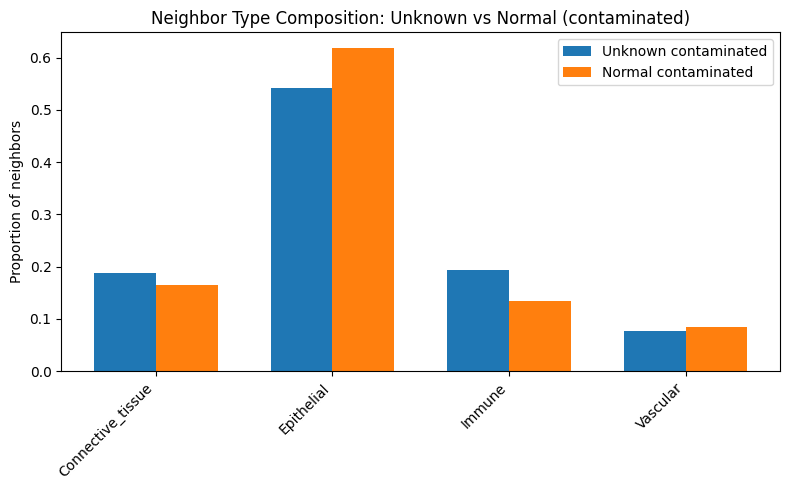


=== Comparison Unknown vs Malignant ===
Chi-square test statistic: 373.471
P-value: 1.2332e-80
The distributions of neighbors differ significantly between Unknown and Malignant.


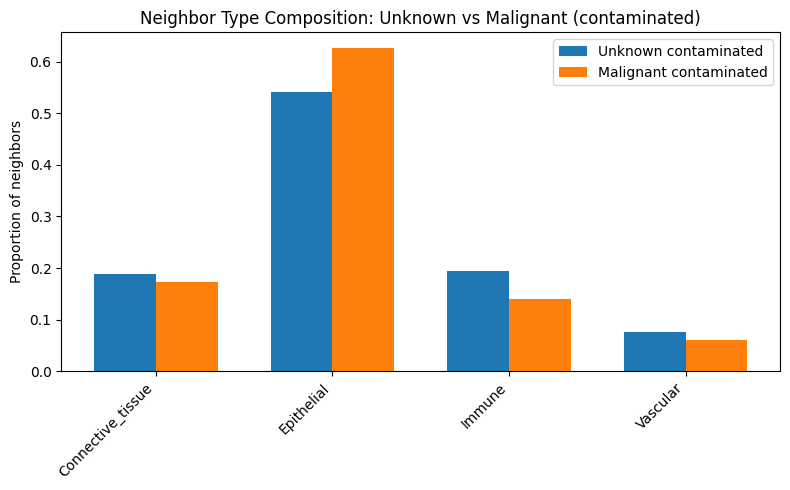


=== Comparison Normal vs Malignant ===
Chi-square test statistic: 303.795
P-value: 1.5013e-65
The distributions of neighbors differ significantly between Normal and Malignant.


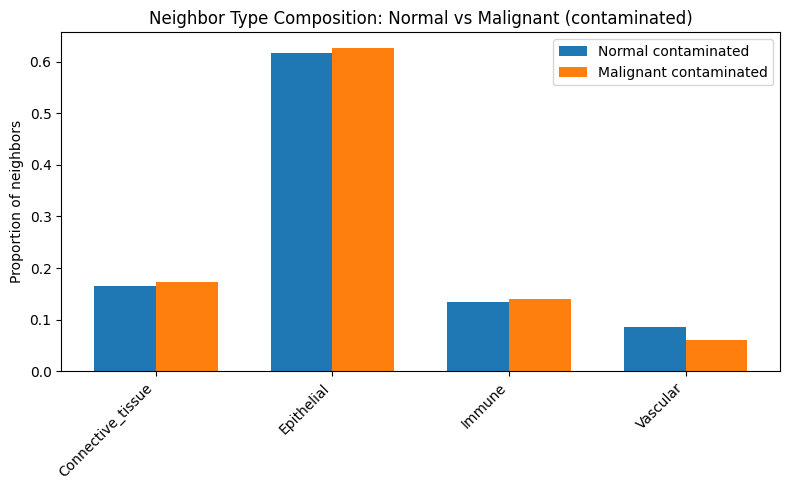


=== Summary of Chi-square test results ===
Unknown vs Normal: p = 1.8313e-87 → SIGNIFICANT
Unknown vs Malignant: p = 1.2332e-80 → SIGNIFICANT
Normal vs Malignant: p = 1.5013e-65 → SIGNIFICANT


In [67]:
# 1. Compare the distribution of contaminating neighbors between two groups
def compare_groups(df, group1, group2):
    sub = df[[group1, group2]]

    chi2, p, dof, expected = chi2_contingency(sub)

    print(f"\n=== Comparison {group1} vs {group2} ===")
    print(f"Chi-square test statistic: {chi2:.3f}")
    print(f"P-value: {p:.4e}")
    if p < 0.05:
        print(f"The distributions of neighbors differ significantly between {group1} and {group2}.")
    else:
        print(f"No significant difference between {group1} and {group2}.")

    # Plot proportions
    sub_norm = sub.div(sub.sum(axis=0), axis=1)

    types = sub_norm.index.tolist()
    x = np.arange(len(types))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, sub_norm[group1], width, label=f'{group1} contaminated')
    ax.bar(x + width/2, sub_norm[group2], width, label=f'{group2} contaminated')

    ax.set_xticks(x)
    ax.set_xticklabels(types, rotation=45, ha="right")
    ax.set_ylabel("Proportion of neighbors")
    ax.set_title(f"Neighbor Type Composition: {group1} vs {group2} (contaminated)")
    ax.legend()

    plt.tight_layout()
    plt.show()

    return p

# 2. Run all comparisons and collect results
p_values = {}
p_values["Unknown vs Normal"] = compare_groups(contingency_df, "Unknown", "Normal")
p_values["Unknown vs Malignant"] = compare_groups(contingency_df, "Unknown", "Malignant")
p_values["Normal vs Malignant"] = compare_groups(contingency_df, "Normal", "Malignant")

# 3. Summary table of p-values
print("\n=== Summary of Chi-square test results ===")
for comp, p in p_values.items():
    sig = "SIGNIFICANT" if p < 0.05 else "not significant"
    print(f"{comp}: p = {p:.4e} → {sig}")

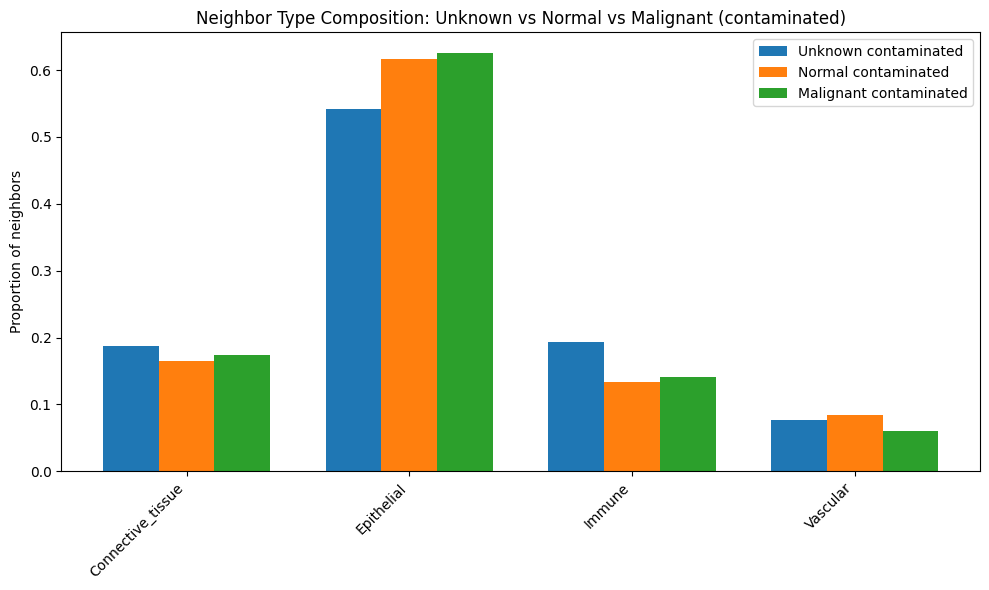

In [68]:
# Normalizza il DataFrame dei conteggi assoluti per ottenere le proporzioni
contingency_norm = contingency_df.div(contingency_df.sum(axis=0), axis=1)

types = contingency_norm.index.tolist()
x = np.arange(len(types))
width = 0.25  # larghezza delle barre

fig, ax = plt.subplots(figsize=(10, 6))

# Barre per ciascun gruppo
ax.bar(x - width, contingency_norm["Unknown"], width, label="Unknown contaminated")
ax.bar(x, contingency_norm["Normal"], width, label="Normal contaminated")
ax.bar(x + width, contingency_norm["Malignant"], width, label="Malignant contaminated")

# Etichette e titolo
ax.set_xticks(x)
ax.set_xticklabels(types, rotation=45, ha="right")
ax.set_ylabel("Proportion of neighbors")
ax.set_title("Neighbor Type Composition: Unknown vs Normal vs Malignant (contaminated)")
ax.legend()

plt.tight_layout()
plt.show()

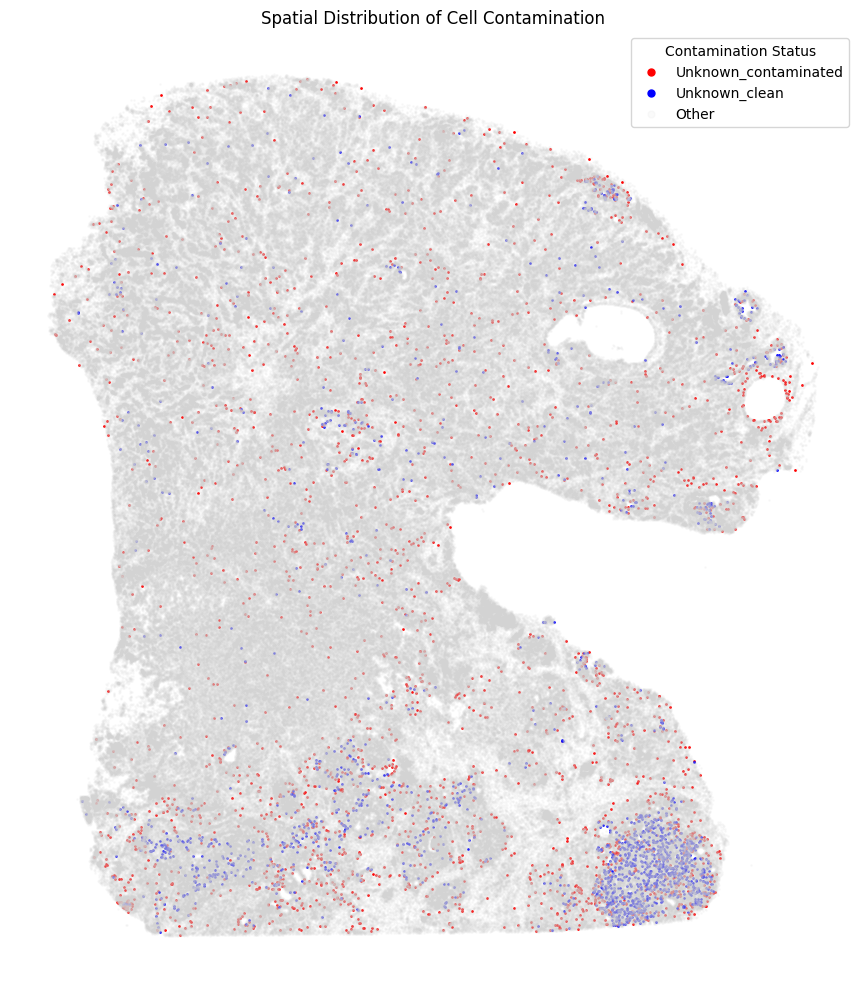

In [69]:
# Visualizzazione spaziale
# Inizializzo colonna
cell_geometries["contamination_status"] = "Other"

# Marca le Unknown contaminate e pulite
contaminated_unknown_ids = neighbors_dfs["Unknown"][neighbors_dfs["Unknown"]["contaminated"]]["unknown_cell_id"]
clean_unknown_ids = neighbors_dfs["Unknown"][~neighbors_dfs["Unknown"]["contaminated"]]["unknown_cell_id"]

cell_geometries.loc[contaminated_unknown_ids, "contamination_status"] = "Unknown_contaminated"
cell_geometries.loc[clean_unknown_ids, "contamination_status"] = "Unknown_clean"

cell_geometries.index = cell_geometries.index.astype(str)


# Obiettivo: le cellule contaminate sono in zone particolari, come bordi tra cluster o vicini ad altri tipi cellulari?
fig, ax = plt.subplots(figsize=(10, 10))

colors = {
    "Unknown_contaminated": "red",
    "Unknown_clean": "blue",
    "Other": "lightgrey"}

for status, color in colors.items():
    subset = cell_geometries[cell_geometries["contamination_status"] == status]
    if status == "Other":
        subset.plot(ax=ax, color=color, markersize=1, label=status, alpha=0.1)  # trasparenza
    else:
        subset.plot(ax=ax, color=color, markersize=1, label=status)

plt.legend(markerscale=5, title="Contamination Status")
plt.title("Spatial Distribution of Cell Contamination")
plt.axis("off")

# Inverto l'asse Y
ax.set_ylim(ax.get_ylim()[::-1])

plt.tight_layout()
plt.show()

In [75]:
# DGE tra Unknown contaminate e Unknown non contaminate
adata = xenium.tables["table"]
neighbors_unknown = neighbors_dfs["Unknown"]

# ID unknown contaminate/pulite
ids_contaminated = neighbors_unknown[neighbors_unknown["contaminated"]]["unknown_cell_id"]
ids_clean = neighbors_unknown[~neighbors_unknown["contaminated"]]["unknown_cell_id"]

all_ids = set(ids_contaminated).union(set(ids_clean))
adata_unknown = adata[adata.obs.index.isin(all_ids)].copy()

# Etichetta gruppi
adata_unknown.obs["contamination_group"] = "clean"
adata_unknown.obs.loc[adata_unknown.obs.index.isin(ids_contaminated), "contamination_group"] = "contaminated"

In [76]:
# Filtra geni espressi in almeno 20 cellule
sc.pp.filter_genes(adata_unknown, min_cells=20)

# Normalizza e log-transform
sc.pp.normalize_total(adata_unknown, target_sum=1e4)
sc.pp.log1p(adata_unknown)
adata_unknown.raw = adata_unknown.copy()

    names     scores  logfoldchanges         pvals     pvals_adj
0     LUM  16.875853        3.198747  6.773910e-64  1.788312e-61
1   POSTN  13.271665        2.086962  3.379879e-40  2.974294e-38
2  CCDC80  12.745356        2.800891  3.308766e-37  1.455857e-35
3   SFRP4   8.581067        2.913828  9.399675e-18  1.654343e-16
4    MMP2   8.508428        2.251167  1.763081e-17  2.909083e-16
5    ENAH   6.639634        0.448095  3.144622e-11  3.320721e-10
6    TCIM   5.627114        1.187893  1.832493e-08  1.612594e-07
7    GJB2   5.314534        2.520915  1.069306e-07  8.821778e-07
8  CXCL12   5.025099        0.805252  5.031717e-07  3.906981e-06
9    ZEB2   4.971451        1.334769  6.645366e-07  4.999466e-06
Number of top DEGs: 23


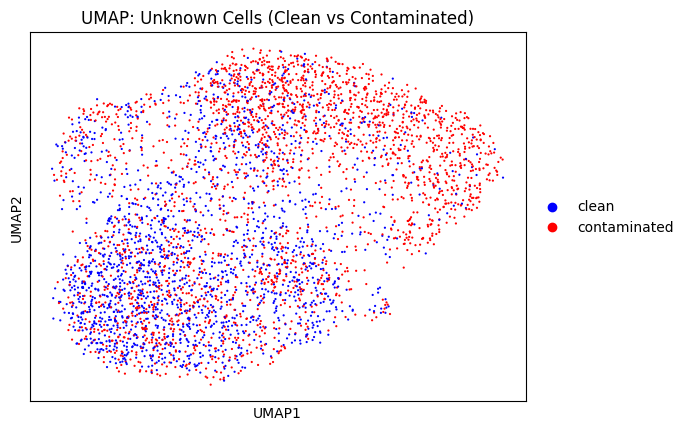

In [94]:
# k=6 
# Calcola vicini e UMAP
sc.pp.neighbors(adata_unknown)
sc.tl.umap(adata_unknown)

# Differential Gene Expression
sc.tl.rank_genes_groups(
    adata_unknown,
    groupby="contamination_group",
    method="wilcoxon",
    use_raw=True
)

# Esporta DGE in DataFrame
deg_df = sc.get.rank_genes_groups_df(adata_unknown, group='contaminated')
print(deg_df.head(10))

# Filtra top geni
top_genes = deg_df[(deg_df['logfoldchanges'] > 0.58) & (deg_df['pvals_adj'] < 0.05)]['names'].tolist()
print(f"Number of top DEGs: {len(top_genes)}")

# Visualizza UMAP
sc.pl.umap(
    adata_unknown,
    color="contamination_group",
    palette={"clean": "blue", "contaminated": "red"},
    title="UMAP: Unknown Cells (Clean vs Contaminated)",
    size=10)

# Cellulee contaminate sono mescolate con le pulite:
# a livello trascrittomico, non c’è una netta separazione tra le due categorie
# contaminazione casuale, legata a vicinanza a cellule non epiteliali?

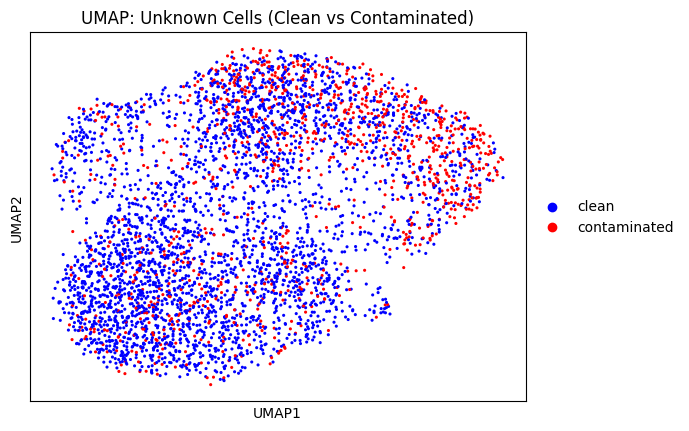

In [830]:
# K=2 UMAP per vedere se le contaminate si raggruppano spazialmente oppure no
sc.pl.umap(
    adata_unknown,
    color="contamination_group",
    palette={"clean": "blue", "contaminated": "red"},
    title="UMAP: Unknown Cells (Clean vs Contaminated)",
    size=20)

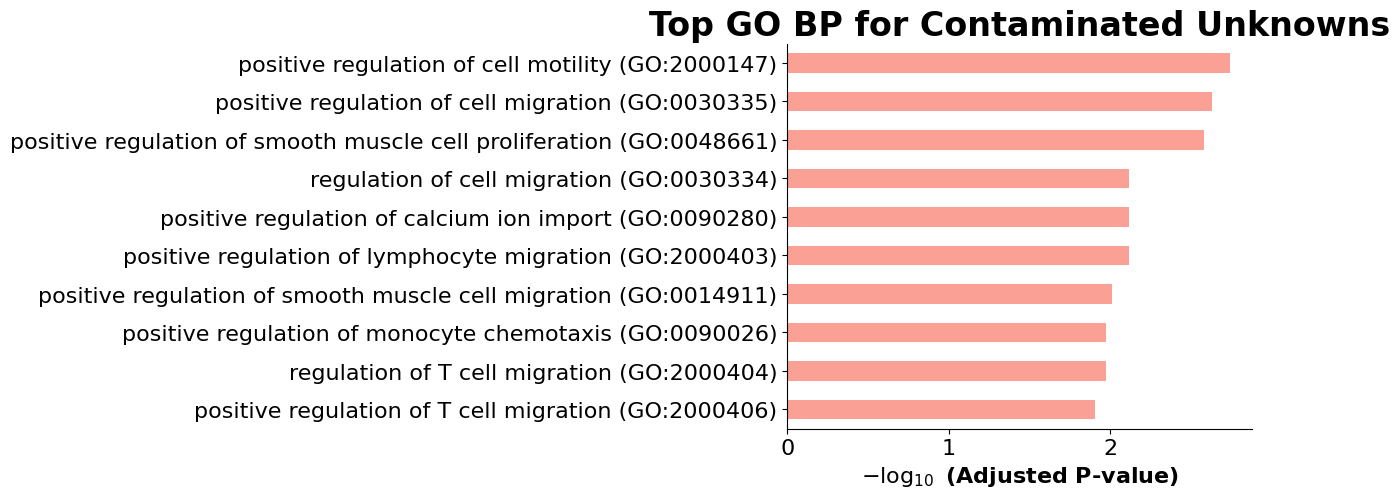

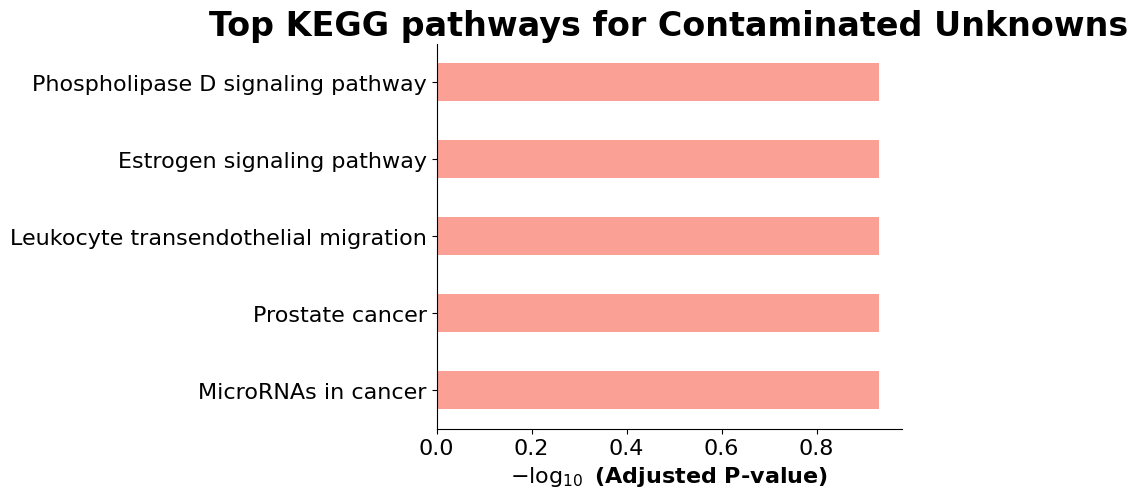

In [95]:
# Enrichment GO/KEGG
if len(top_genes) > 0:
    enr_go = gp.enrichr(
        gene_list=top_genes,
        gene_sets=['GO_Biological_Process_2021'],
        organism='Human',
        outdir='enrichr_results/go',
        cutoff=0.15
    )

    enr_kegg = gp.enrichr(
        gene_list=top_genes,
        gene_sets=['KEGG_2021_Human'],
        organism='Human',
        outdir='enrichr_results/kegg',
        cutoff=0.15
    )

    gp.barplot(enr_go.res2d, title='Top GO BP for Contaminated Unknowns', cutoff=0.15, figsize=(6,5))
    gp.barplot(enr_kegg.res2d, title='Top KEGG pathways for Contaminated Unknowns', cutoff=0.15, figsize=(6,5))
else:
    print("No top DEGs found for enrichment.")

In [ ]:
# GO
# le cellule contaminate mostrano segnali trascrizionali associati alla migrazione e alle 
# interazioni con il microambiente, coerente con l’idea che la contaminazione possa derivare 
# dal vicinato con altre cellule (epiteliali o immunitarie)

# KEGG
# i DEGs nelle cellule contaminate hanno attività trascrizionali sia legate a fenomeni maligni 
# che a interazioni con cellule immunitarie o microambiente

In [113]:
# Le cellule Unknown sono premaligne? Estrarre espressione dei marker nelle cellule Unknown
premalignant_markers = ['MKI67', 'SNAI1', 'ZEB1']

# Controlla quali marker sono presenti
present_markers = [gene for gene in premalignant_markers if gene in adata_unknown.var_names]
print("Marker presenti nei dati:", present_markers)

Marker presenti nei dati: ['MKI67', 'SNAI1', 'ZEB1']


In [114]:
# Estraggo l’espressione dei marker nelle cellule Unknown
if len(present_markers) == 0:
    print("Nessun marker premaligno presente nei dati")
else:
    marker_expr_df = pd.DataFrame(
        adata_unknown[:, present_markers].X.toarray() if hasattr(adata_unknown.X, "toarray") else adata_unknown[:, present_markers].X,
        index=adata_unknown.obs.index,
        columns=present_markers
    )

    # Aggiungi il gruppo di contaminazione
    marker_expr_df['contamination_group'] = adata_unknown.obs['contamination_group']

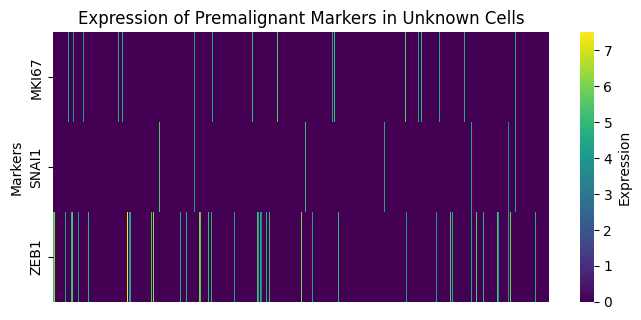

                        MKI67     SNAI1      ZEB1
contamination_group                              
clean                0.104480  0.038286  0.265083
contaminated         0.117011  0.074206  0.624460


In [118]:
# Heatmap dei marker premaligni

if marker_expr_df.shape[0] == 0:
    print("Nessuna cellula Unknown da plottare")
else:
    plt.figure(figsize=(8, len(present_markers)*0.5 + 2))
    sns.heatmap(
        marker_expr_df[present_markers].T,
        cmap="viridis",
        cbar_kws={'label':'Expression'},
        xticklabels=False
    )
    plt.title("Expression of Premalignant Markers in Unknown Cells")
    plt.ylabel("Markers")
    plt.show()

# Calcolo l'espressione media per ciascun gruppo
mean_expr = marker_expr_df.groupby('contamination_group').mean()
print(mean_expr)


In [120]:
premalignant_markers = ["MKI67", "SNAI1", "ZEB1"]
results = []

for gene in premalignant_markers:
    clean_vals = adata_unknown[adata_unknown.obs["contamination_group"]=="clean"].to_df()[gene]
    contaminated_vals = adata_unknown[adata_unknown.obs["contamination_group"]=="contaminated"].to_df()[gene]
    
    stat, p = mannwhitneyu(clean_vals, contaminated_vals, alternative='two-sided')
    results.append({"gene": gene, "stat": stat, "p-value": p})

results_df = pd.DataFrame(results)
print(results_df)

# le cellule Unknown contaminate esprimono significativamente più ZEB1 rispetto alle Unknown pulite

    gene       stat       p-value
0  MKI67  2270760.5  6.574960e-01
1  SNAI1  2260039.0  4.712922e-02
2   ZEB1  2106511.5  3.189242e-16


In [123]:
# Confronto Unknown contaminate e Malignant per capire quanto le prime siano “vicine” allo stato maligno.
# 1. Estraggo le cellule da confrontare
# IDs delle Malignant
malignant_ids = xenium.tables["table"].obs.index[
    xenium.tables["table"].obs["cell_type_prediction"] == "Malignant"]

# IDs delle Unknown contaminate
unknown_contaminated_ids = neighbors_dfs["Unknown"][neighbors_dfs["Unknown"]["contaminated"]]["unknown_cell_id"]

# Sottodataframe
adata_compare = adata[adata.obs.index.isin(list(malignant_ids) + list(unknown_contaminated_ids))].copy()

# Etichetta i gruppi
adata_compare.obs['group'] = 'Malignant'
adata_compare.obs.loc[adata_compare.obs.index.isin(unknown_contaminated_ids), 'group'] = 'Unknown_contaminated'


In [124]:
# Analisi dell’espressione dei marker premaligni
premalignant_markers = ["MKI67", "SNAI1", "ZEB1"]

# Estraggo l’espressione
marker_expr_df = pd.DataFrame(
    adata_compare[:, premalignant_markers].X.toarray() if hasattr(adata_compare.X, "toarray") else adata_compare[:, premalignant_markers].X,
    index=adata_compare.obs.index,
    columns=premalignant_markers)

# Aggiungo il gruppo
marker_expr_df['group'] = adata_compare.obs['group']

# Media per gruppo
mean_expr = marker_expr_df.groupby('group').mean()
print(mean_expr)

                         MKI67     SNAI1      ZEB1
group                                             
Malignant             0.078840  0.014440  0.066480
Unknown_contaminated  0.026786  0.017045  0.168425


In [125]:
results = []
for gene in premalignant_markers:
    vals_unknown = marker_expr_df[marker_expr_df['group'] == 'Unknown_contaminated'][gene]
    vals_malignant = marker_expr_df[marker_expr_df['group'] == 'Malignant'][gene]
    
    stat, p = mannwhitneyu(vals_unknown, vals_malignant, alternative='two-sided')
    results.append({"gene": gene, "stat": stat, "p-value": p})

results_df = pd.DataFrame(results)
print(results_df)

    gene        stat       p-value
0  MKI67  29604697.0  9.870752e-15
1  SNAI1  30868501.5  3.596271e-01
2   ZEB1  33122643.5  3.457337e-51
